In [1]:
suppressWarnings({suppressMessages({
    library(dplyr)
    library(ggplot2)
    library(readr) # read_tsv
#     library(grid)
    library(gridExtra) # grid.arrange
    library(cowplot) # plot_grid
    library(ggpubr)
})})

options(repr.plot.width = 20, repr.plot.height = 12)

# Function

## Dados

In [2]:
# Dados de exemplo
df_data = data.frame(
    pos = c(50, 220, 230, 440, 650, 860),
    samples = c(30, 50, 20, 40, 15, 25),
    label = c("Texto 1", "Texto 2", "Texto 3", "Texto 4", "Texto 5", "Texto 6"),
    vaf = c(0.5, 0.7, 0.4, 0.5, 0.4, 0.8),
    mutation = c("Missense", "Missense", "Frameshift", "Missense", "Frameshift", "Frameshift")
)
df_domains = data.frame(
    start = 1,
    end = 1000,
    name = NA
)

df_domains = rbind(
    df_domains,
    data.frame(
        start = c(10, 450),
        end = c(100, 600),
        name = c("aa", "bb")
    )
)

## Old

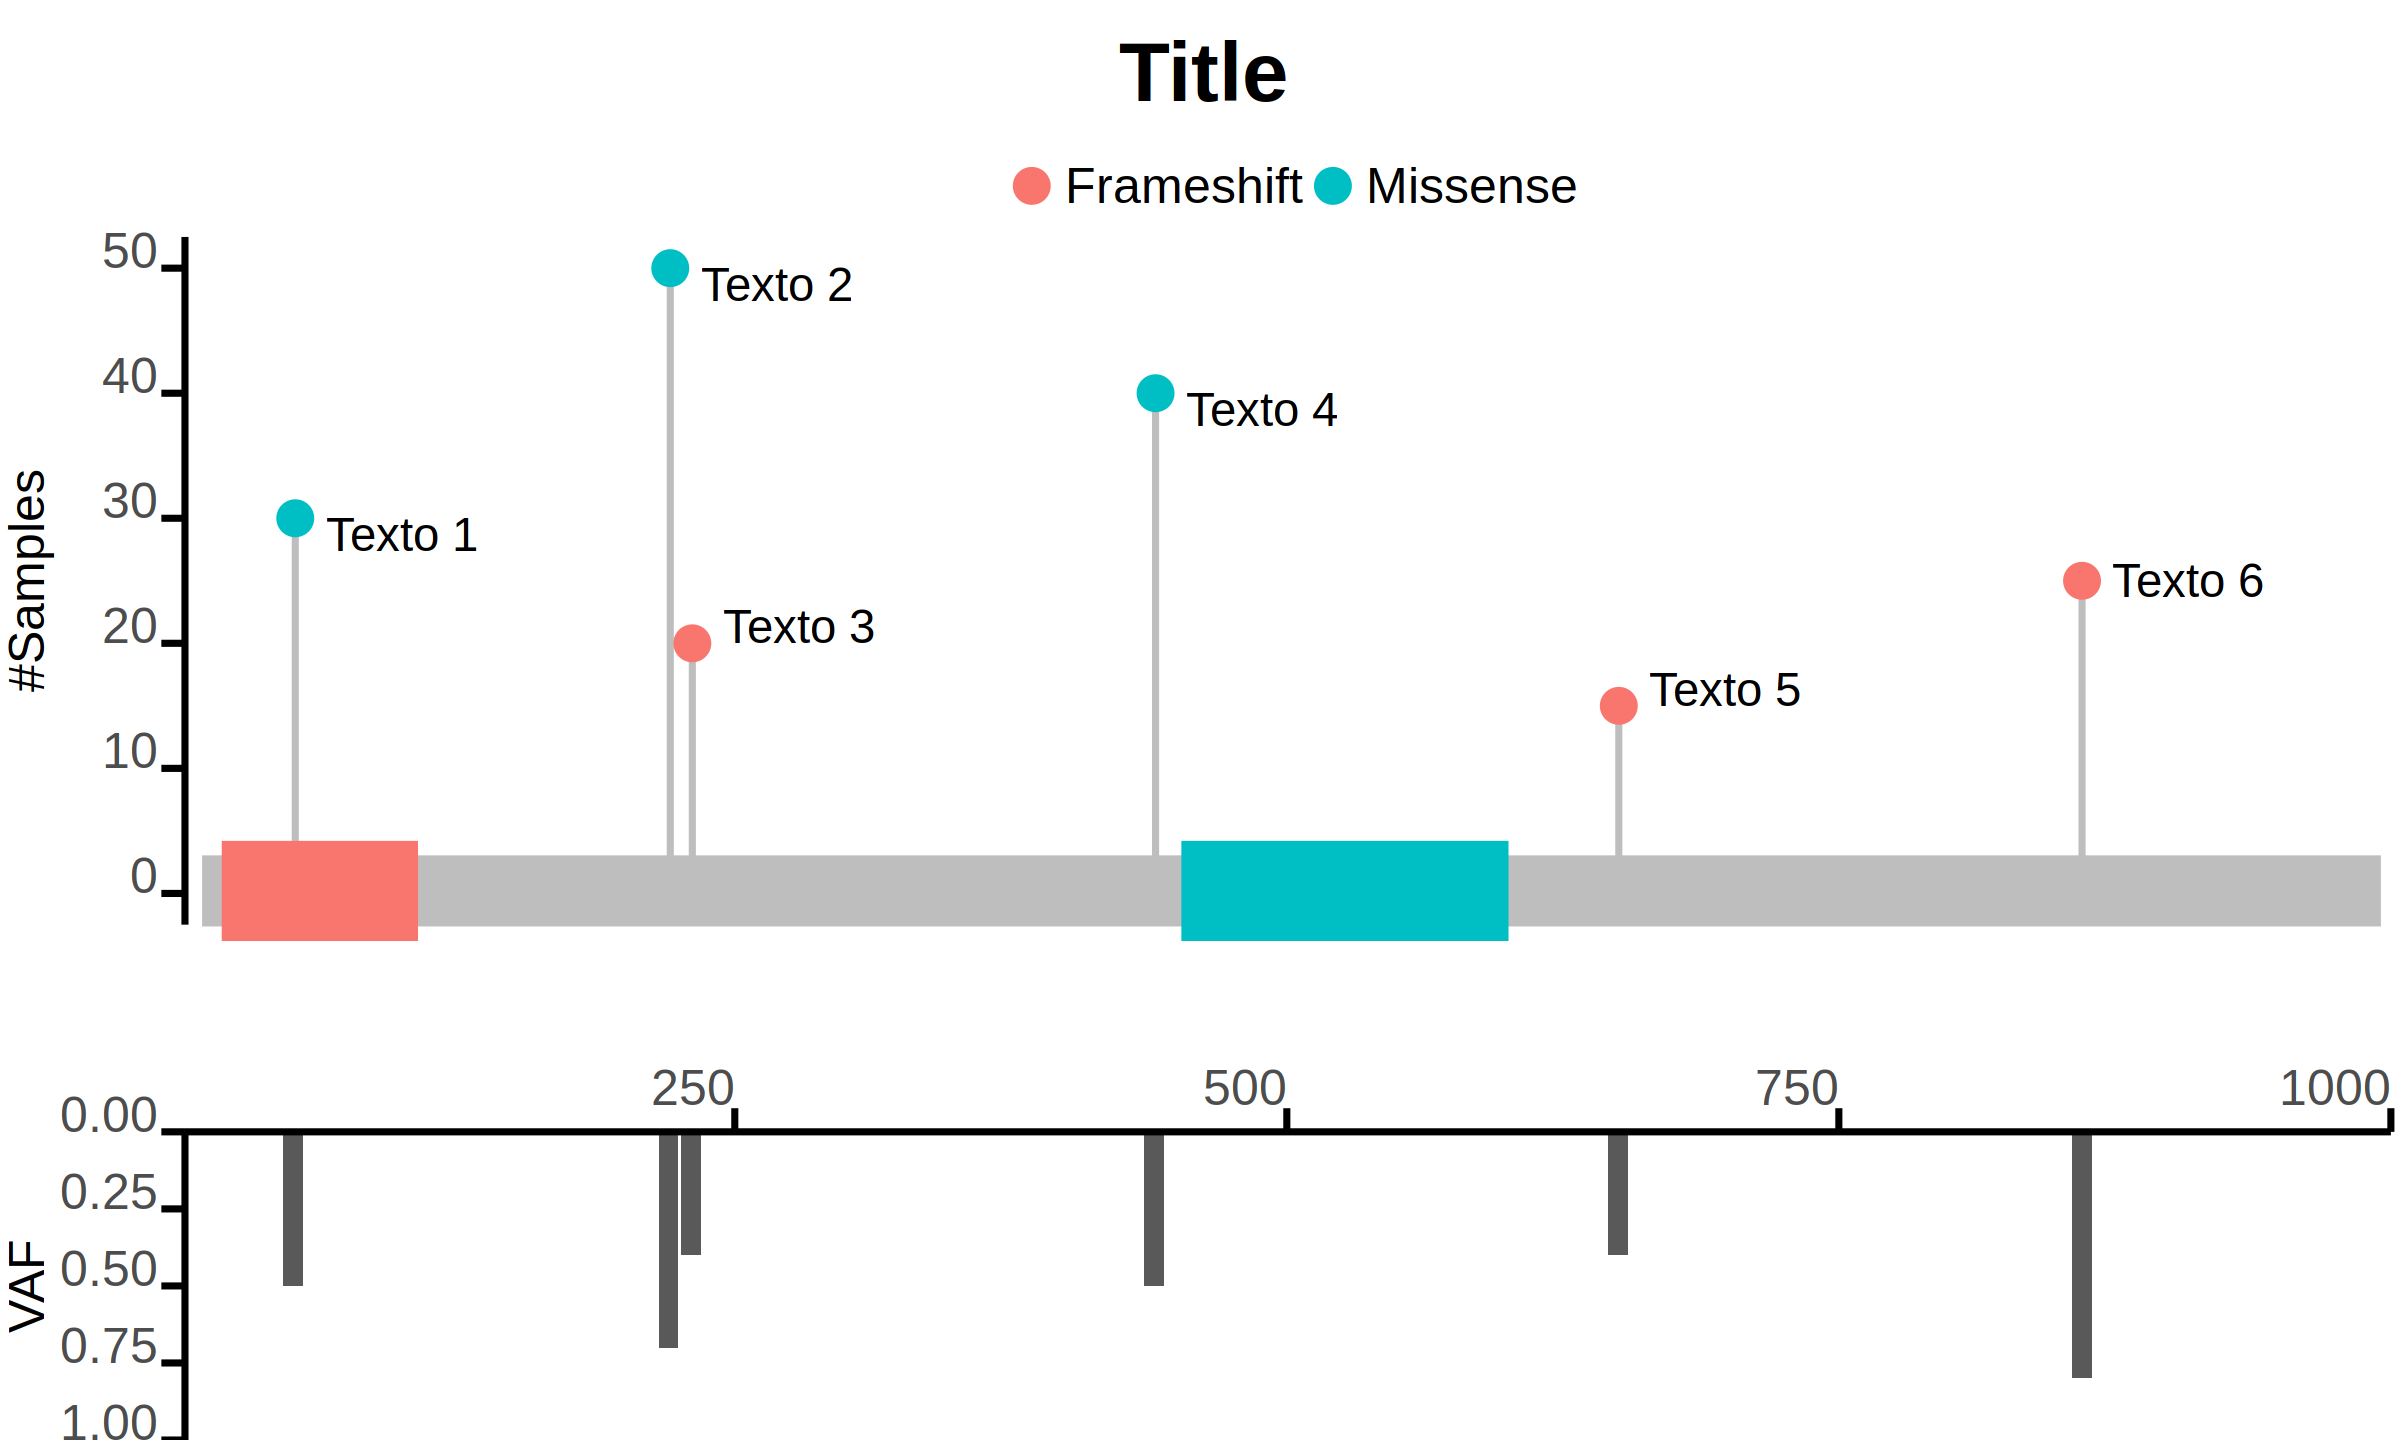

In [3]:
dgg_lollipop_old = function(data, domains, title = "", plot_vaf = FALSE) {
    protein_size = max(domains$end)
    
    # rel_heights
    rel_heights = c()
    if (plot_vaf) {
        rel_heights = c(1/10, 6/10, 3/10)
    } else {
        rel_heights = c(1/10, 8/10, 1/10)
    }
    
    # title
    p_title = ggdraw() +
        draw_label(
            label = title,
            fontface = "bold",
            size = 50,
            x = 0.5,
            hjust = 1
        )
    
    # lollipop
    p_lollipop = ggplot(
        data = data,
        mapping = aes(x = pos)
    ) +
        geom_segment( # vertical lines
            mapping = aes(y = samples, xend = pos, yend = 0),
            color = "gray",
            linewidth = 2
        ) +
        geom_point( # dots
            mapping = aes(y = samples, color = mutation),
            size = 10
        ) +
        geom_text( # text
            mapping = aes(y = samples, label = label),
            size = 10,
            vjust = "inward",
            hjust = -0.2
        ) +
        scale_x_continuous(
            expand = c(0,0),
            limits = c(0,protein_size)
        ) +
        coord_cartesian(clip = "off") +
        theme_minimal() +
        theme(
            panel.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text = element_text(size = 30, vjust = 0, hjust = 1),
            axis.line = element_line(color = "black", linewidth=2),
            axis.text.x = element_blank(),
            axis.line.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.ticks = element_line(linewidth=2),
            axis.ticks.length = unit(0.5, "cm"),
            axis.title = element_text(size = 30),
            legend.position = "top",
            legend.text = element_text(size=30)
        ) +
        scale_color_discrete(name = NULL) +
        labs(x = "", y = "#Samples")
    
    # p_domains
    p_domains = ggplot(
        data = domains,
        mapping = aes(x=0)
    ) +
        geom_segment(
            mapping = aes(y = end, xend = 0, yend = start),
            color = "gray",
            linewidth = 20
        ) +
        geom_segment(
            data = na.omit(domains),
            mapping = aes(y = end, xend = 0, yend = start, color = name),
            linewidth = 30
        ) +
        rotate() +
        scale_y_continuous(expand = c(0,0), limits = c(0,protein_size)) +
        theme_transparent() +
        theme(
            legend.position = "none"
        )
    p_domains_grob = ggplotGrob(p_domains) # grob
    
    # p_lollipop_domains
    p_lollipop_domains = p_lollipop +
        annotation_custom(
            grob = p_domains_grob,
            xmin = 0,
            xmax = protein_size,
            ymin = -5,
            ymax = 5
        )
    
    # vaf
    p_vaf = ggplot(
        data = data,
        mapping = aes(x = pos, y = vaf)
    ) +
        geom_bar(
            stat = "identity",
            position = "dodge"
        ) +
        scale_x_continuous(expand = c(0,0), limits = c(1,protein_size), position = "top") +
        scale_y_reverse(expand = c(0,0), limits = c(1,0)) +
        theme_minimal() +
        theme(
            panel.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text = element_text(size = 30, vjust = 0, hjust = 1),
            axis.line = element_line(color = "black", linewidth=2),
            axis.ticks = element_line(linewidth=2),
            axis.ticks.length = unit(0.5, "cm"),
            axis.title = element_text(size = 30),
            plot.margin = unit(c(0,0,0,0), "mm"),
            legend.position = "none"
        ) +
        labs(x = "", y = "VAF")
    
    # merge plots
    p = plot_grid(
        p_title,
        p_lollipop_domains,
        p_vaf,
        nrow = 3,
        align = "v",
        rel_heights = c(1/10, 6/10, 3/10)
    )
    
    return(p)
}

dgg_lollipop_old(
    data = df_data,
    domains = df_domains,
    title = "Title"
)

## New (plot vaf option)

In [4]:
dgg_lollipop = function(data, domains, title = "", plot_vaf = FALSE) {
    protein_size = max(domains$end)
    
    # title
    p_title = ggdraw() +
        draw_label(
            label = title,
            fontface = "bold",
            size = 50,
            x = 0.5,
            hjust = 1
        )
    
    # lollipop
    p_lollipop = ggplot(
        data = data,
        mapping = aes(x = pos)
    ) +
        geom_segment( # vertical lines
            mapping = aes(y = samples, xend = pos, yend = 0),
            color = "gray",
            linewidth = 2
        ) +
        geom_point( # dots
            mapping = aes(y = samples, color = mutation),
            size = 10
        ) +
        geom_text( # text
            mapping = aes(y = samples, label = label),
            size = 10,
            vjust = "inward",
            hjust = -0.2
        ) +
        scale_x_continuous(
            expand = c(0,0),
            limits = c(0,protein_size)
        ) +
        coord_cartesian(clip = "off") +
        theme_minimal() +
        theme(
            panel.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text = element_text(size = 30, vjust = 0, hjust = 1),
            axis.line = element_line(color = "black", linewidth=2),
            axis.text.x = element_blank(),
            axis.line.x = element_blank(),
            axis.ticks.x = element_blank(),
            axis.ticks = element_line(linewidth=2),
            axis.ticks.length = unit(0.5, "cm"),
            axis.title = element_text(size = 30),
            legend.position = "top",
            legend.text = element_text(size=30)
        ) +
        scale_color_discrete(name = NULL) +
        labs(x = "", y = "#Samples")
    
    # p_domains
    p_domains = ggplot(
        data = domains,
        mapping = aes(x=0)
    ) +
        geom_segment(
            mapping = aes(y = end, xend = 0, yend = start),
            color = "gray",
            linewidth = 20
        ) +
        geom_segment(
            data = na.omit(domains),
            mapping = aes(y = end, xend = 0, yend = start, color = name),
            linewidth = 30
        ) +
        rotate() +
        scale_y_continuous(expand = c(0,0), limits = c(0,protein_size)) +
        theme_transparent() +
        theme(
            legend.position = "none"
        )
    p_domains_grob = ggplotGrob(p_domains) # grob
    
    # p_lollipop_domains
    p_lollipop_domains = p_lollipop +
        annotation_custom(
            grob = p_domains_grob,
            xmin = 0,
            xmax = protein_size,
            ymin = -5,
            ymax = 5
        )
    
    # vaf
    if (plot_vaf) {
        p_vaf  = ggplot(
            data = data,
            mapping = aes(x = pos, y = vaf)
        ) +
            geom_bar(
                stat = "identity",
                position = "dodge"
            ) +
            scale_x_continuous(expand = c(0,0), limits = c(1,protein_size), position = "top") +
            scale_y_reverse(expand = c(0,0), limits = c(1,0)) +
            theme_minimal() +
            theme(
                axis.text = element_text(size = 30, vjust = 0, hjust = 1),
                axis.line = element_line(color = "black", linewidth = 2),
                axis.ticks = element_line(linewidth = 2)
            ) +
            labs(x = "", y = "VAF")
    } else {
        p_vaf  = ggplot(
            data = data,
            mapping = aes(x = pos, y = 0)
        ) +
            geom_bar(
                stat = "identity",
                position = "dodge"
            ) +
            scale_x_continuous(expand = c(0,0), limits = c(1,protein_size), position = "top") +
            scale_y_reverse(expand = c(0,0)) +
            theme_minimal() +
            theme(
                axis.text.x = element_text(size = 30, vjust = 0, hjust = 1),
                axis.line.x = element_line(color = "black", linewidth = 2),
                axis.ticks.x = element_line(linewidth = 2)
            ) +
            labs(x = "", y = "")
    }
    p_vaf = p_vaf +
        theme(
            panel.background = element_blank(),
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.ticks.length = unit(0.5, "cm"),
            axis.title = element_text(size = 30),
            plot.margin = unit(c(0,0,0,0), "mm"),
            legend.position = "none"
        )
    
    # rel_heights
    rel_heights = c()
    if (plot_vaf) {
        rel_heights = c(1/10, 6/10, 3/10)
    } else {
        rel_heights = c(1/10, 8/10, 1/10)
    }
    
    # merge plots
    p = plot_grid(
        p_title,
        p_lollipop_domains,
        p_vaf,
        nrow = 3,
        align = "v",
        rel_heights = rel_heights
    )
    
    return(p)
}

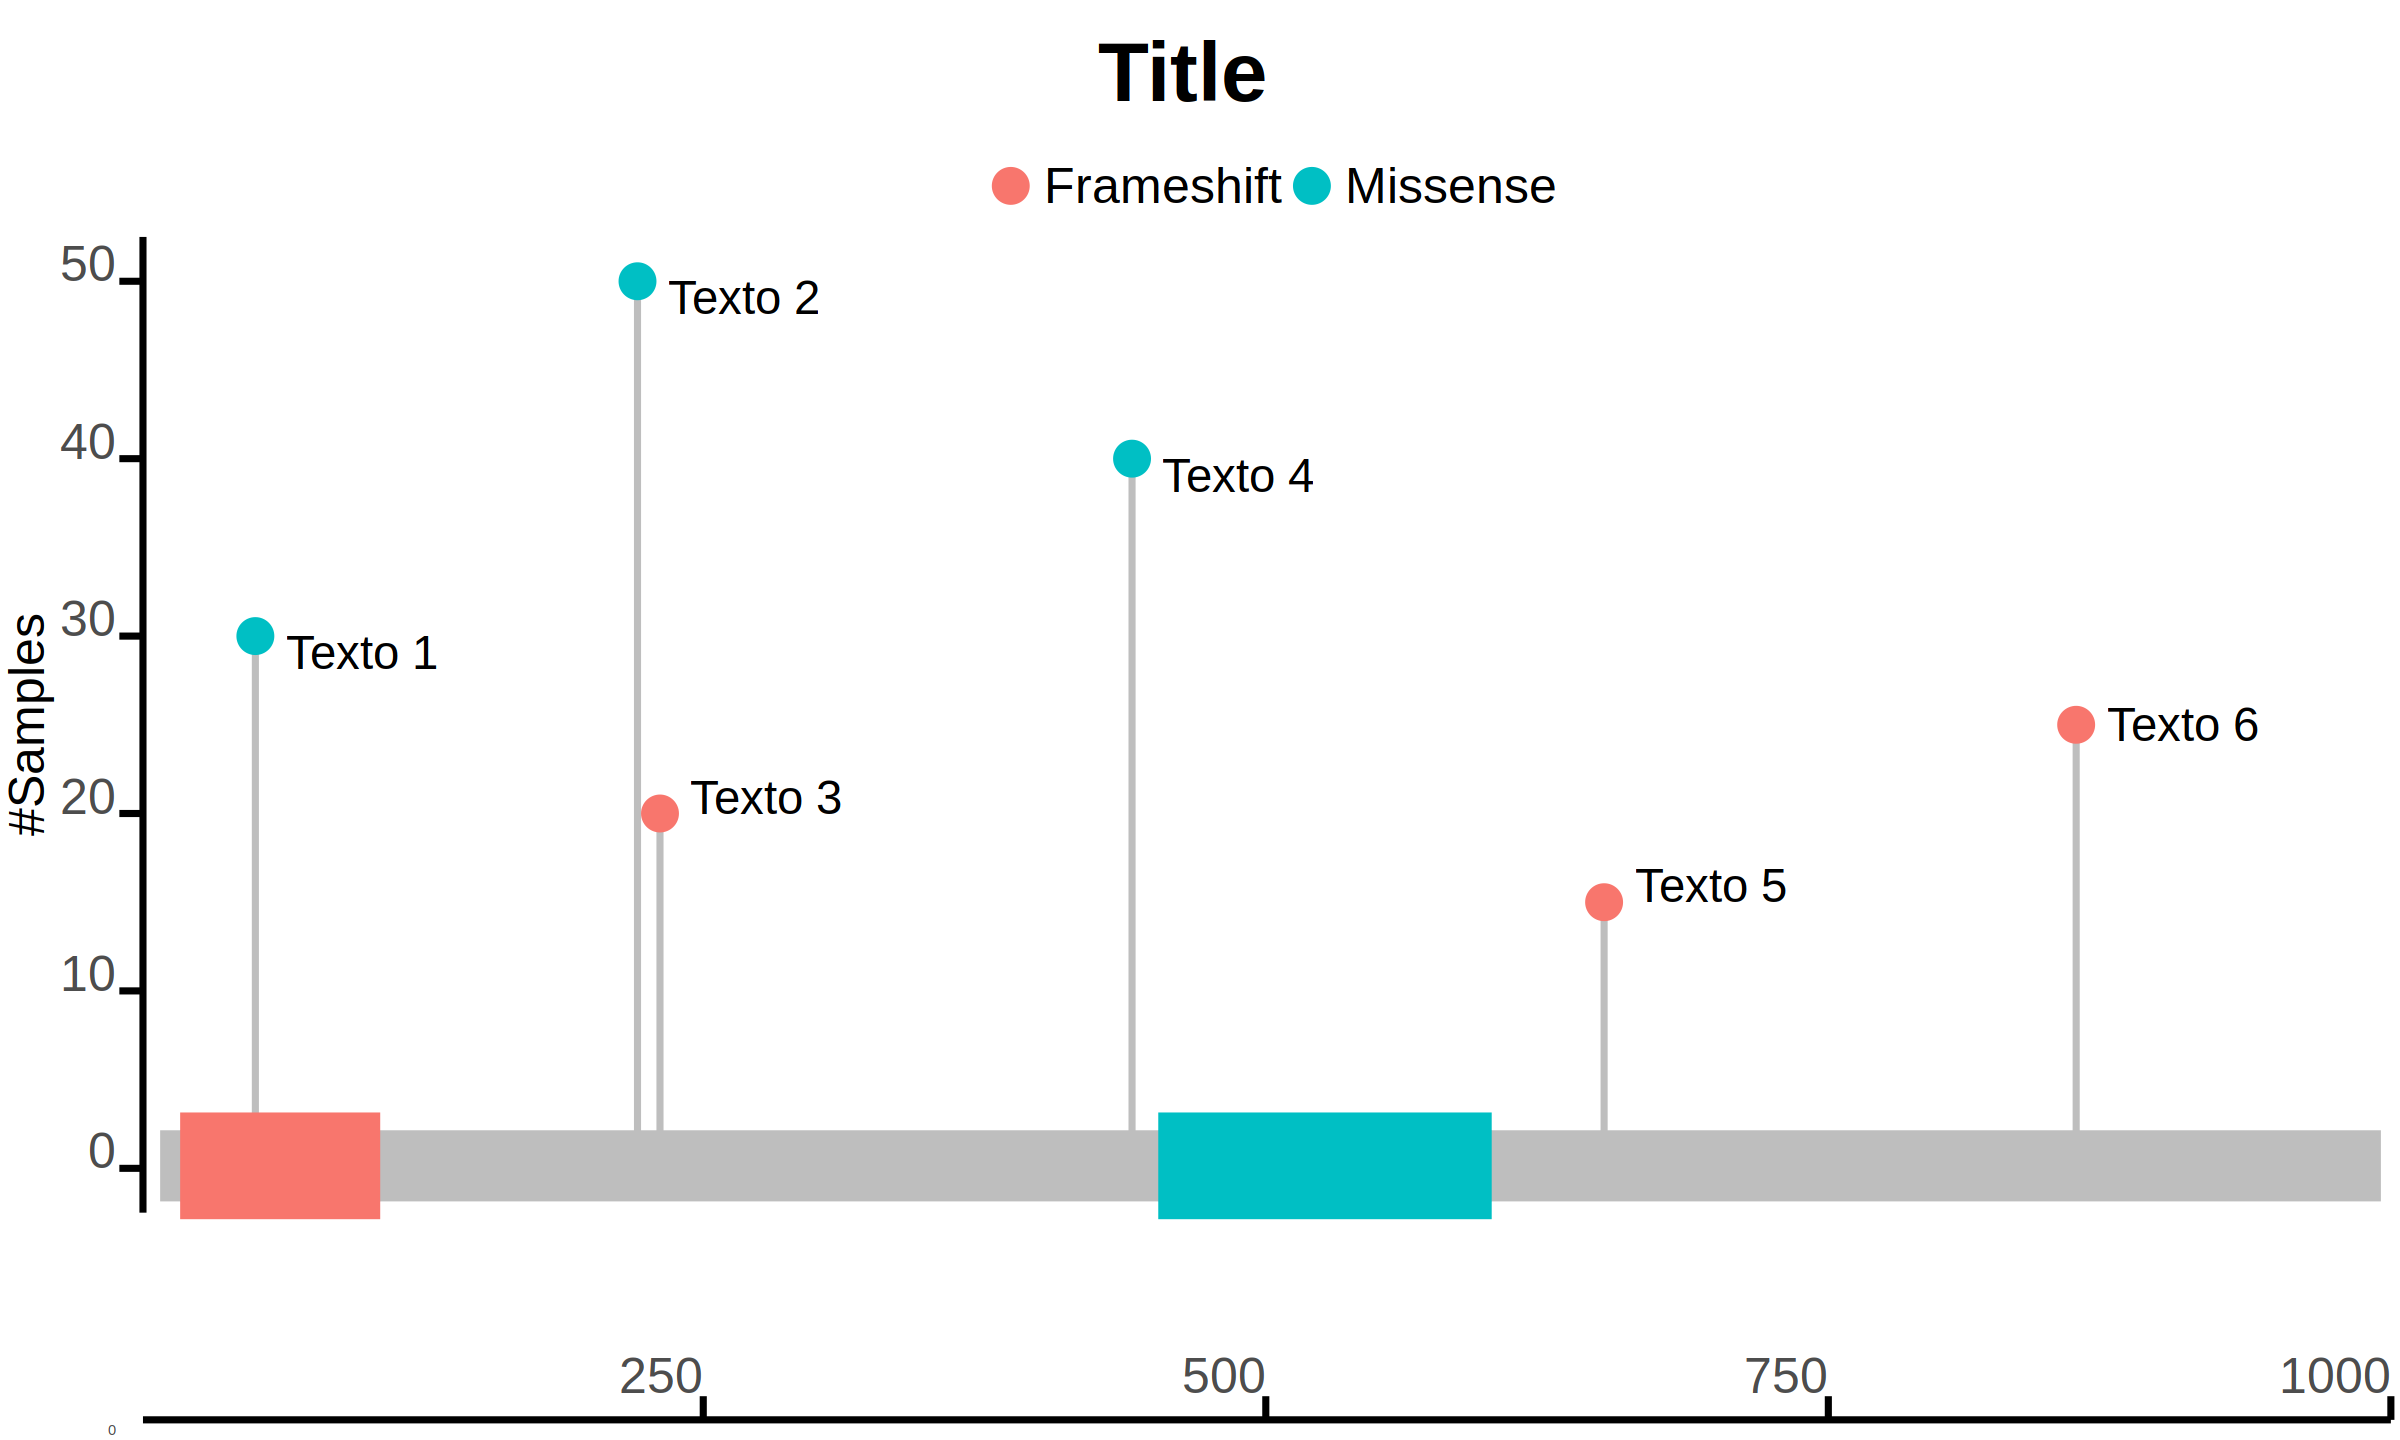

In [5]:
dgg_lollipop(
    data = df_data,
    domains = df_domains,
    title = "Title",
    plot_vaf = FALSE
)

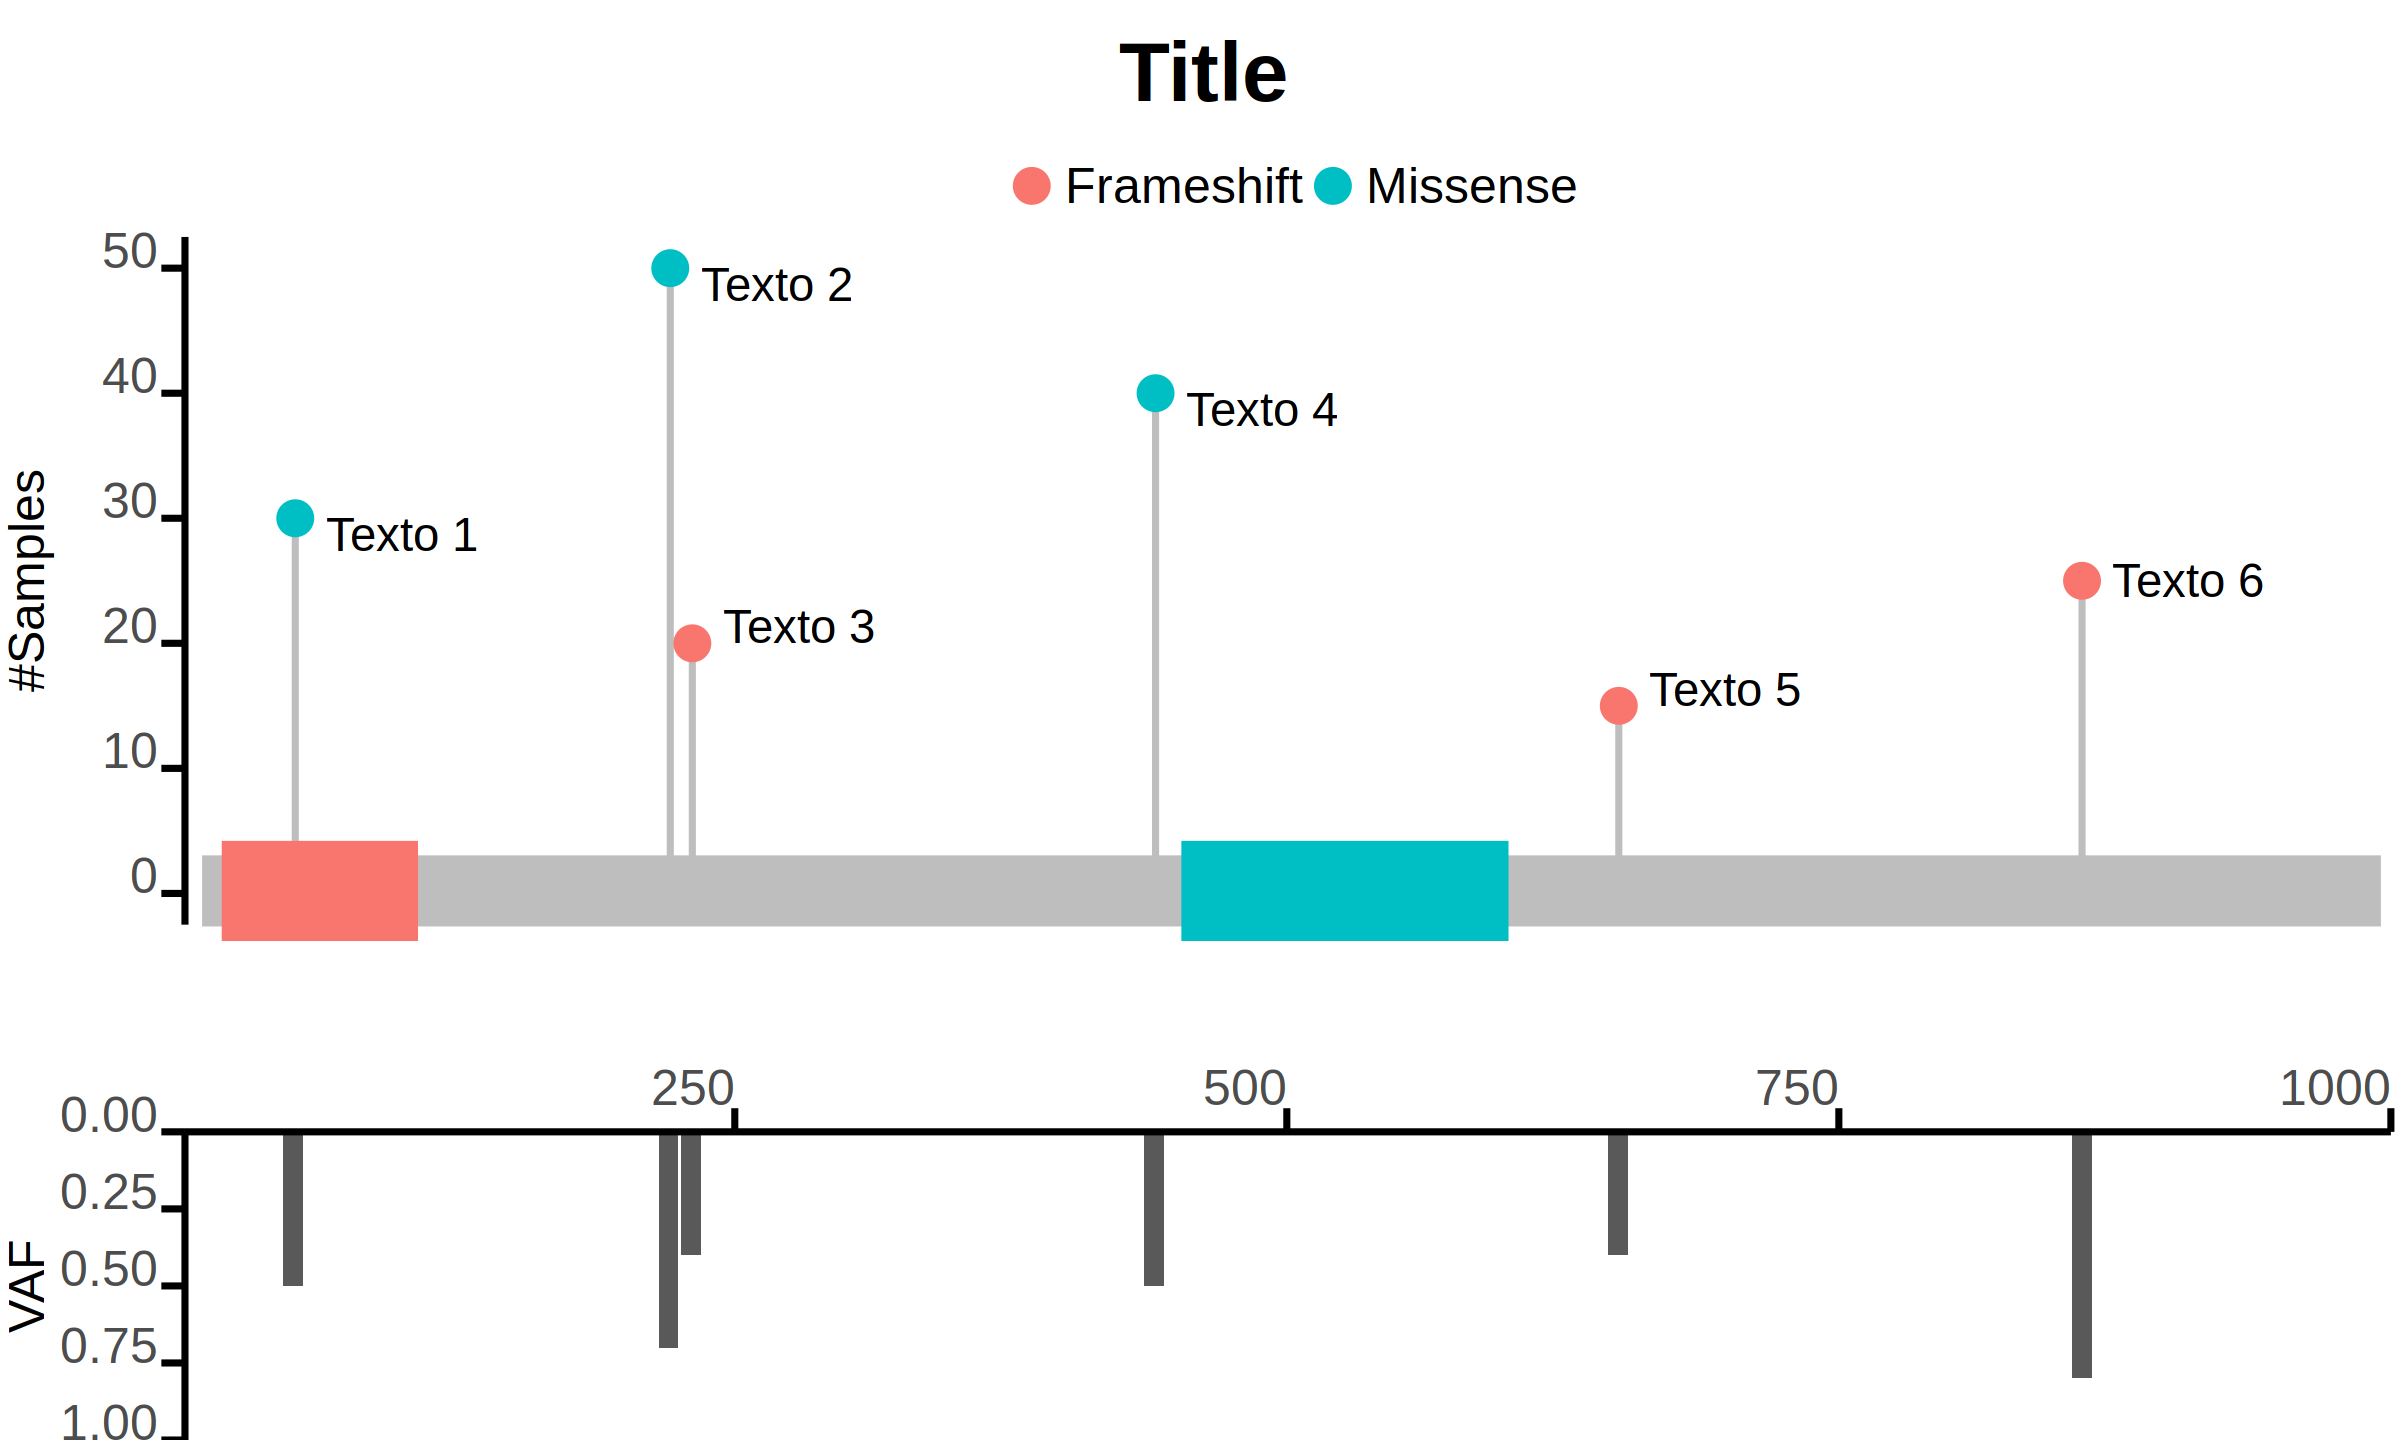

In [6]:
dgg_lollipop(
    data = df_data,
    domains = df_domains,
    title = "Title",
    plot_vaf = TRUE
)

# Script separado

## Dados

In [7]:
# Dados de exemplo
data = data.frame(
    pos = c(50, 220, 230, 440, 650, 860),
    samples = c(30, 50, 20, 40, 15, 25),
    label = c("Texto 1", "Texto 2", "Texto 3", "Texto 4", "Texto 5", "Texto 6"),
    vaf = c(0.5, 0.7, 0.4, 0.5, 0.4, 0.8),
    mutation = c("Missense", "Missense", "Frameshift", "Missense", "Frameshift", "Frameshift")
)

protein_size = 1000

title_plot = "Title"

domains = data.frame(
    start = 1,
    end = protein_size,
    name = NA
)

domains = rbind(
    domains,
    data.frame(
        start = c(10, 450),
        end = c(100, 600),
        name = c("aa", "bb")
    )
)

## Title

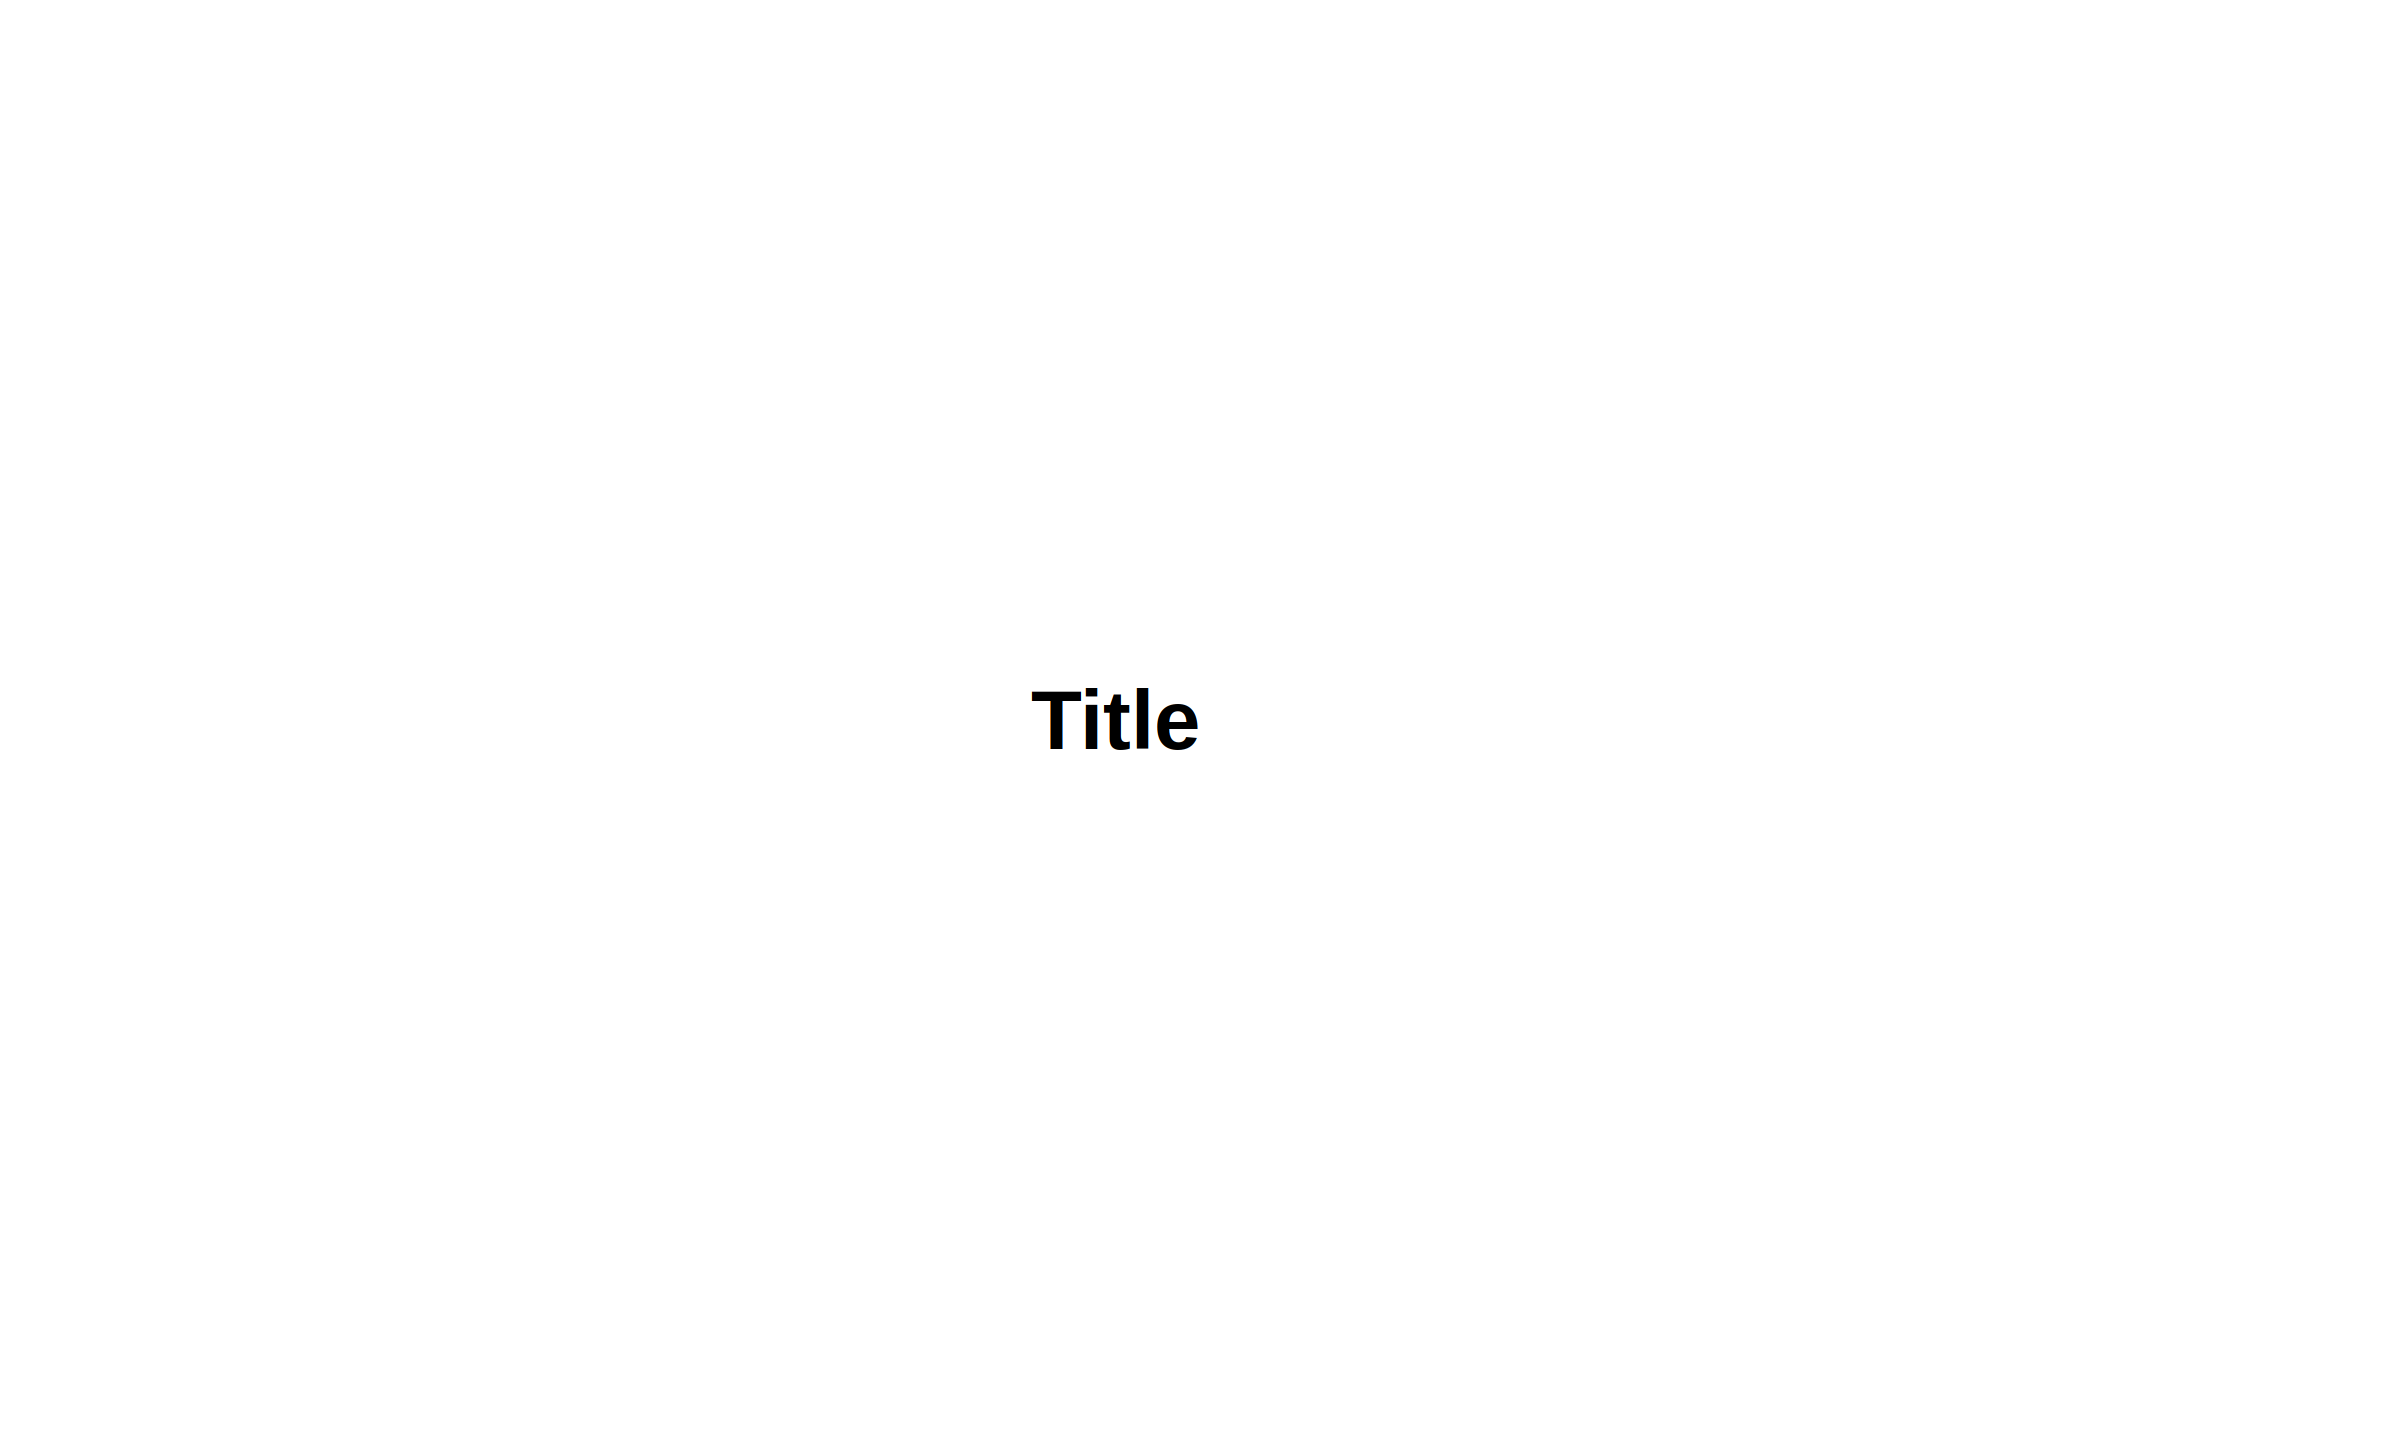

In [8]:
title = ggdraw() +
    draw_label(
        label = title_plot,
        fontface = "bold",
        size = 50,
        x = 0.5,
        hjust = 1
    )

title

## Lollipop

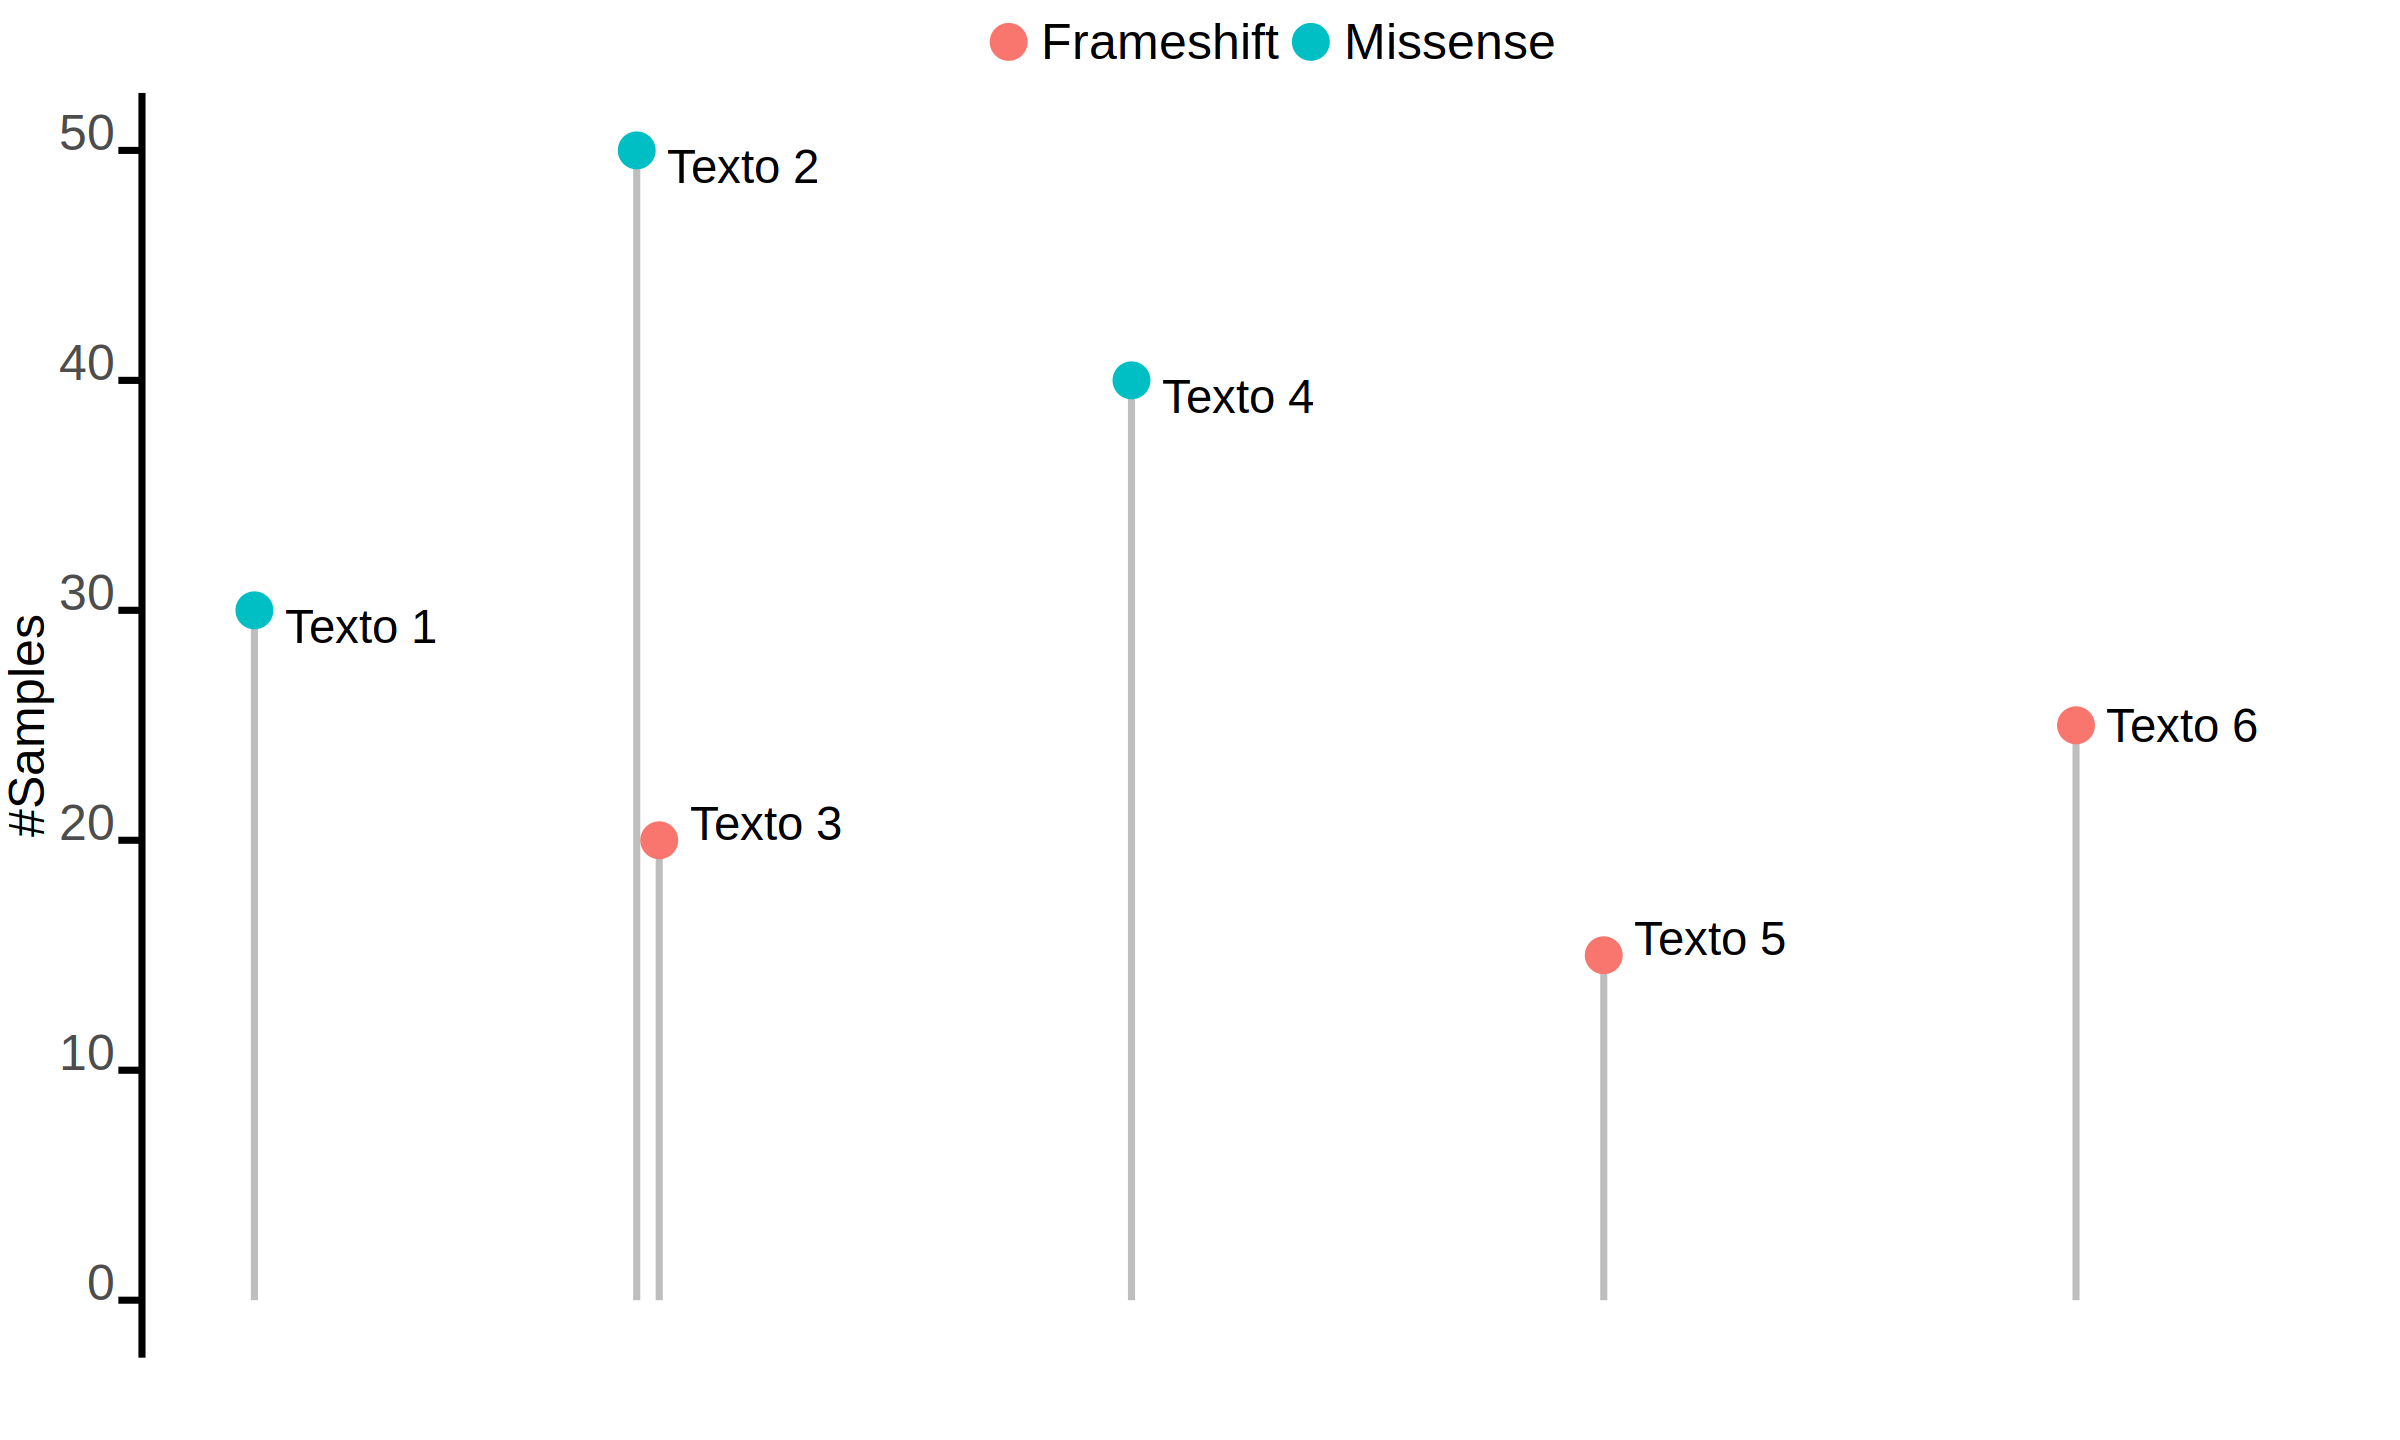

In [9]:
p1 = ggplot(data, aes(x = pos)) +
    geom_segment(aes(y = samples, xend = pos, yend = 0), color = "gray", linewidth=2) +  # vertical lines
    geom_point(mapping = aes(y = samples, color = mutation), size = 10) +  # dots
    geom_text(aes(y = samples, label = label), size = 10, vjust="inward", hjust=-0.2) +  # text
    scale_x_continuous(expand = c(0,0), limits = c(0,protein_size)) +
    coord_cartesian(clip = "off") +
    theme_minimal() +
    theme(
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        
        axis.text = element_text(size = 30, vjust = 0, hjust = 1),
        axis.line = element_line(color = "black", linewidth=2),
        
        axis.text.x = element_blank(),
        axis.line.x = element_blank(),
        axis.ticks.x = element_blank(),
        
        axis.ticks = element_line(linewidth=2),
        axis.ticks.length = unit(0.5, "cm"),
        
        axis.title = element_text(size = 30),
        
#         plot.margin = unit(c(0,0,0,0), "mm"),
        
        legend.position = "top",
        legend.text = element_text(size=30)
    ) +
    scale_color_discrete(name = NULL) +
    labs(x = "", y = "#Samples")

p1

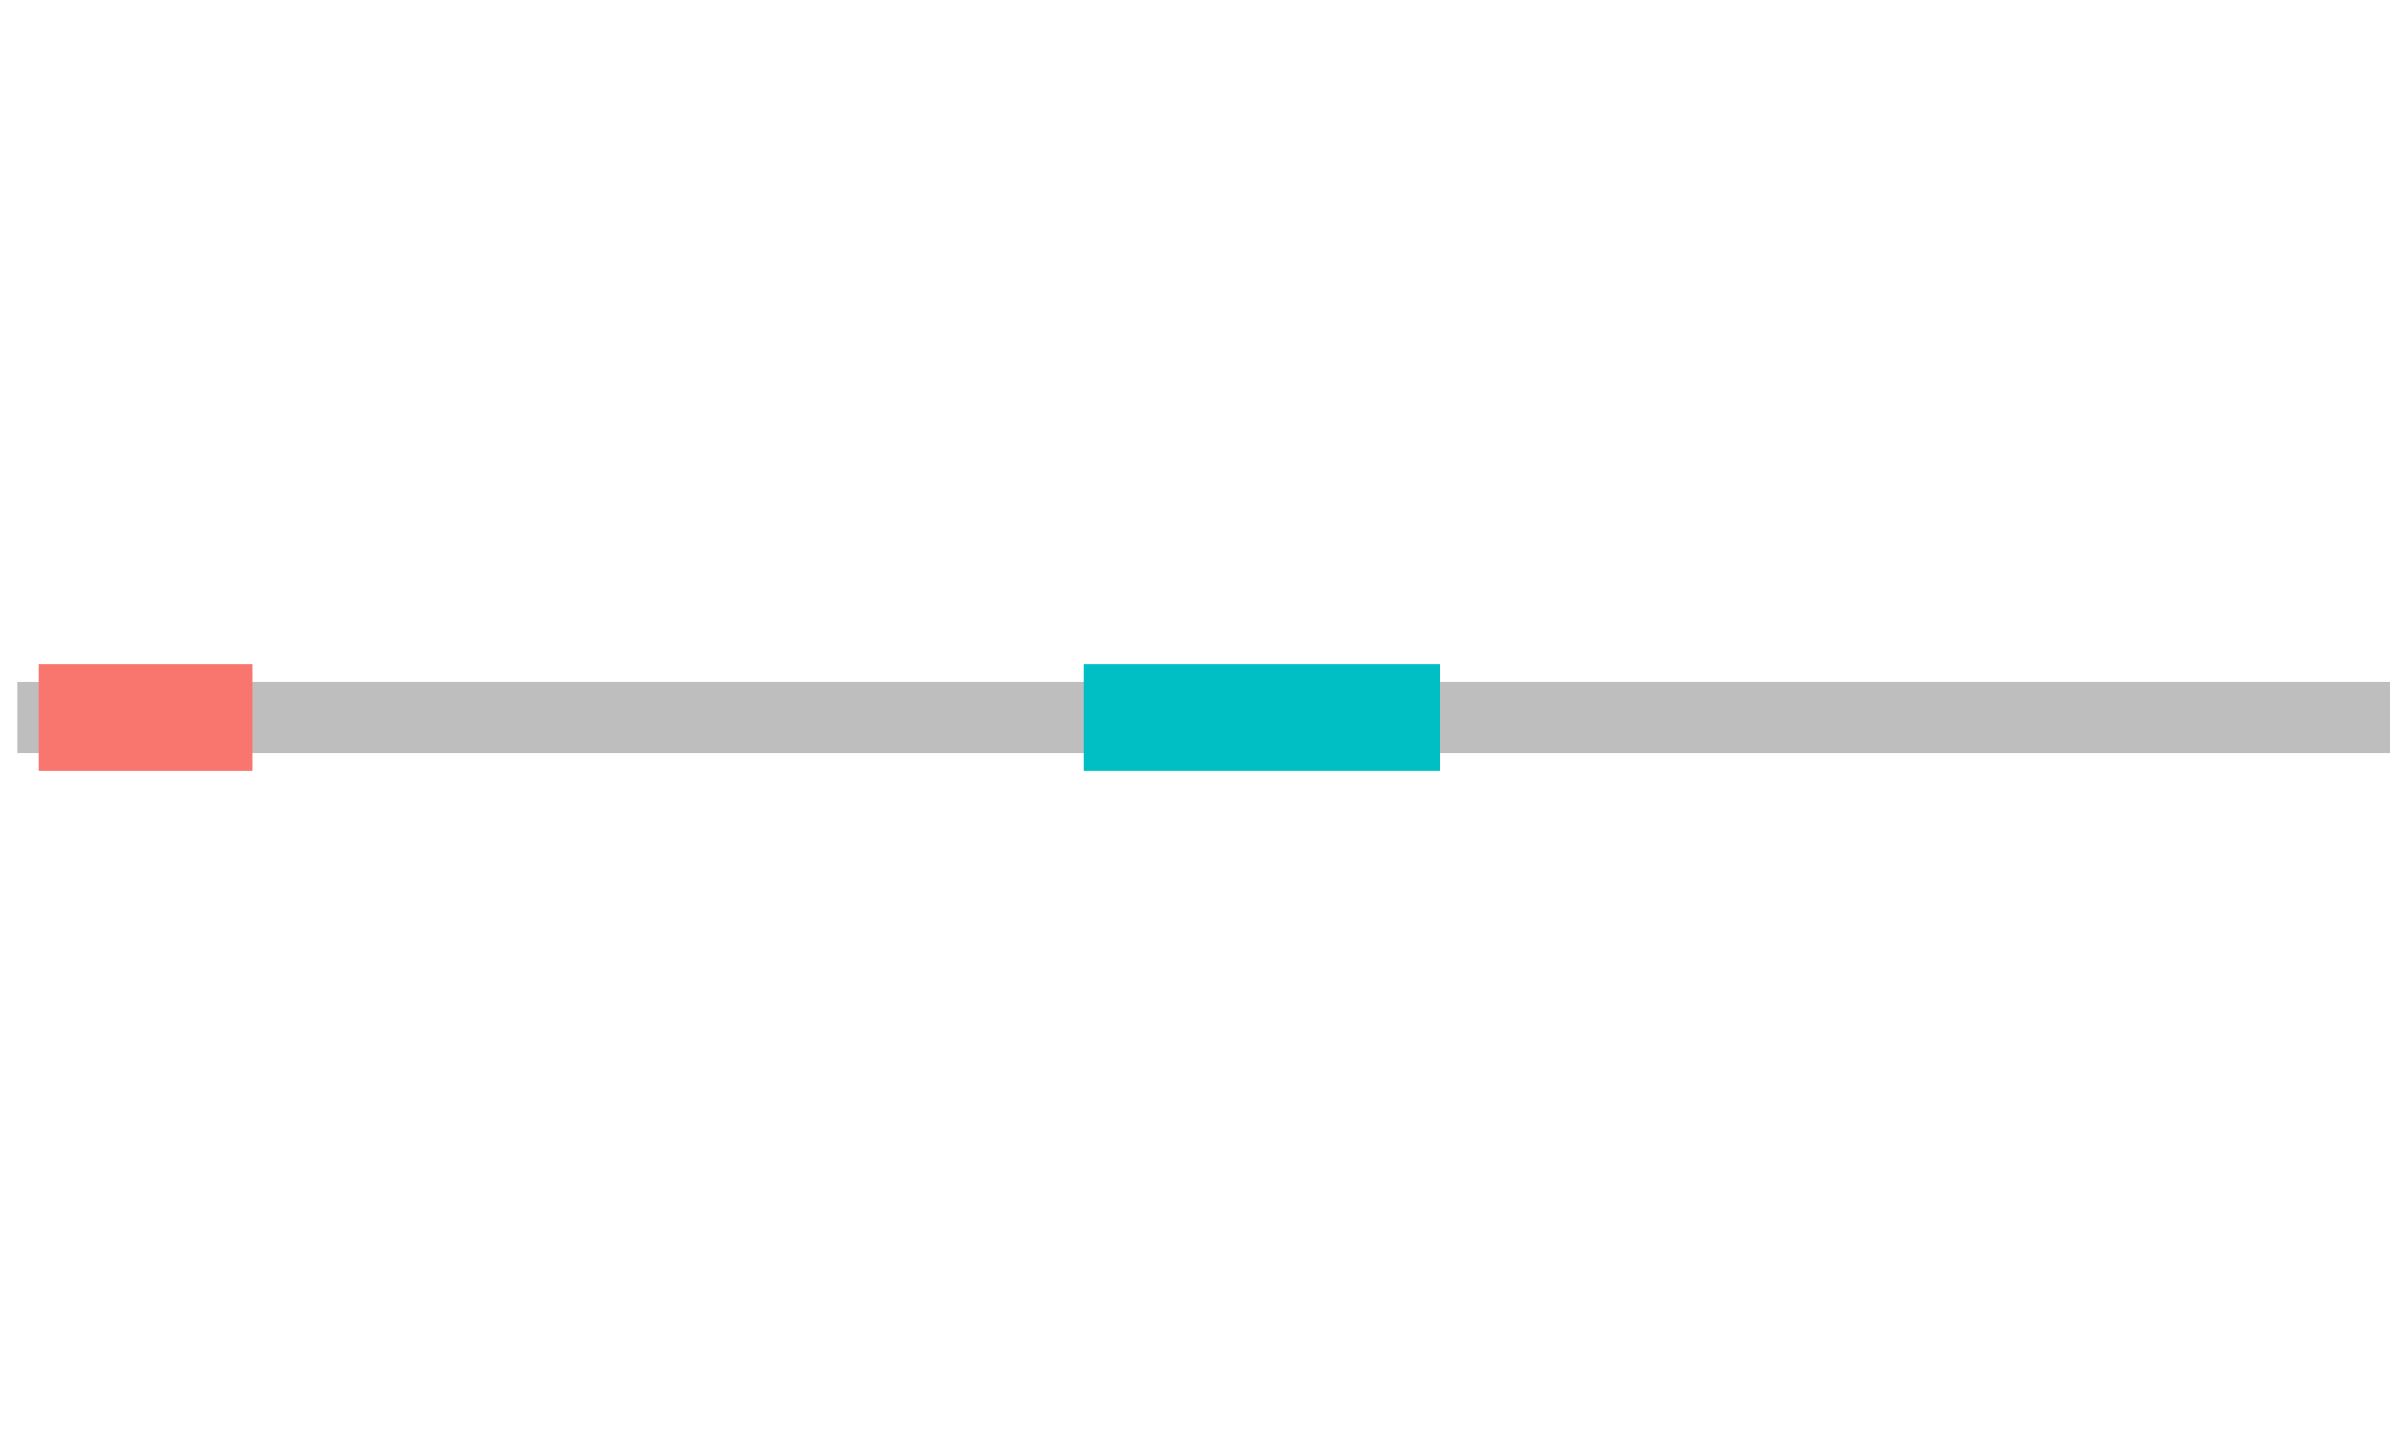

In [10]:
p2 = ggplot(domains, aes(x=0)) +
    geom_segment(aes(y = end, xend = 0, yend = start), color = "gray", linewidth=20) +
    geom_segment(data = na.omit(domains),aes(y = end, xend = 0, yend = start, color = name), linewidth=30) +
    rotate() +
    scale_y_continuous(expand = c(0,0), limits = c(0,protein_size)) +
    theme_transparent() +
    theme(
        legend.position = "none"
    )
p2

# grob
p2_grob = ggplotGrob(p2)

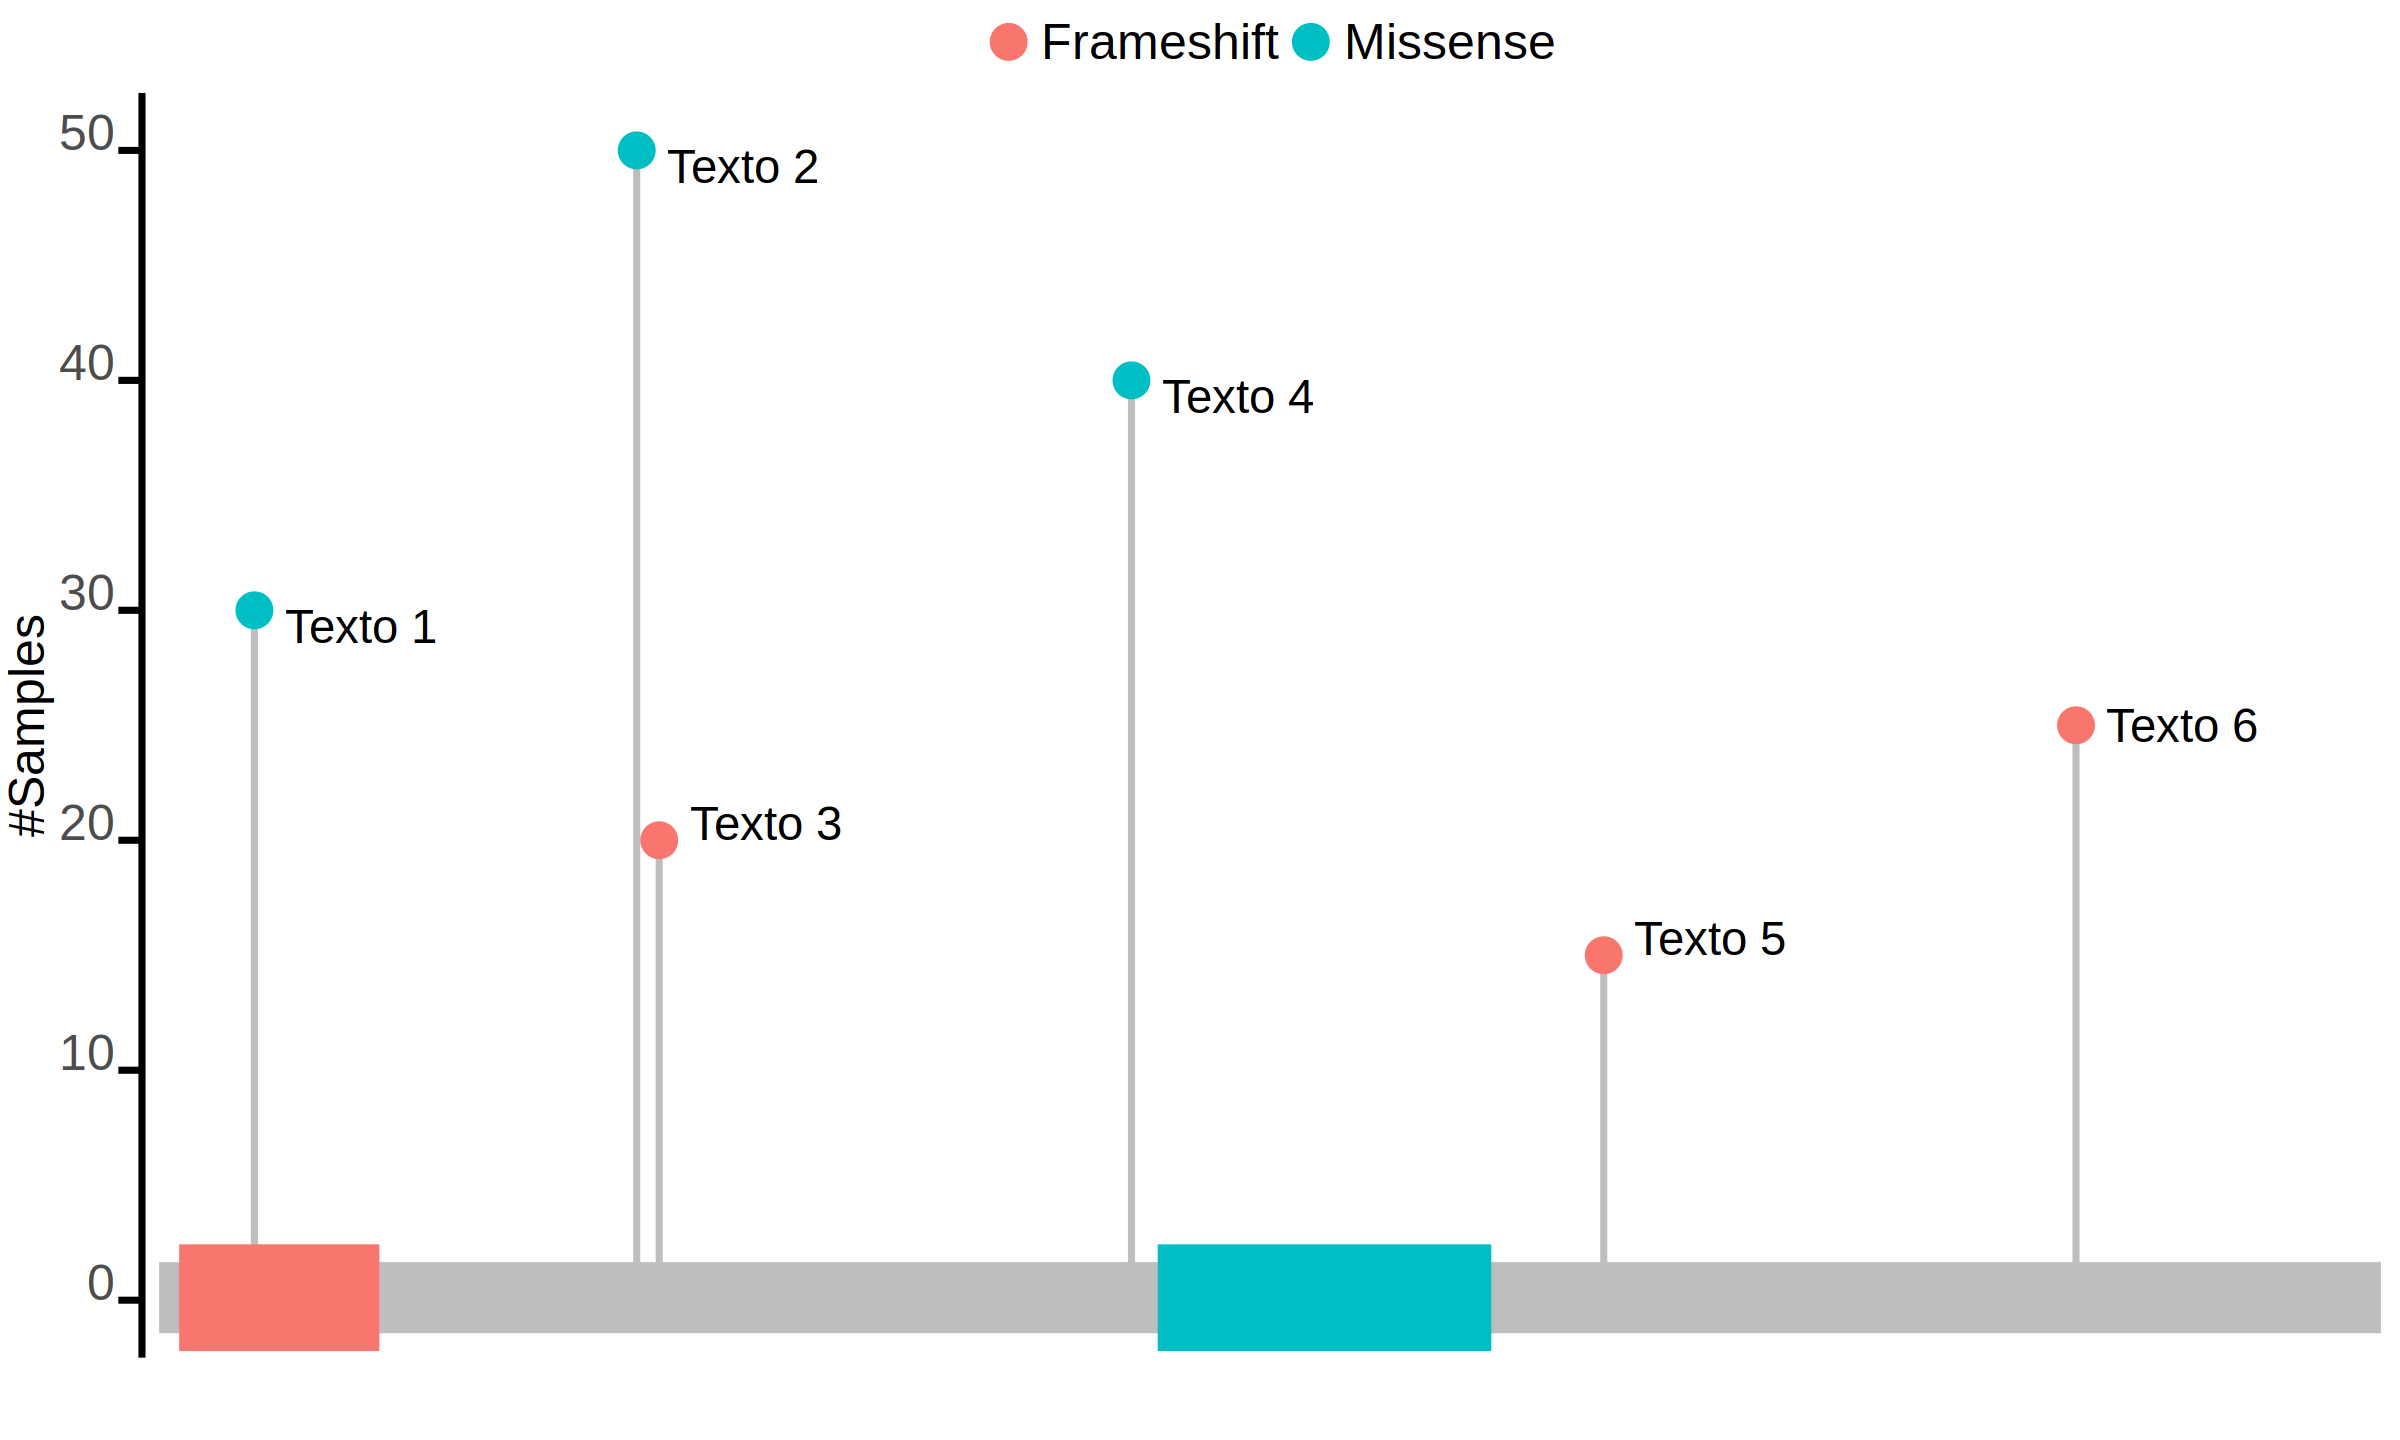

In [11]:
lollipop = p1 +
    # domains
    annotation_custom(
        grob = p2_grob,
        xmin = 0,
        xmax = protein_size,
        ymin = -5,
        ymax = 5
    )

lollipop

## Histogram

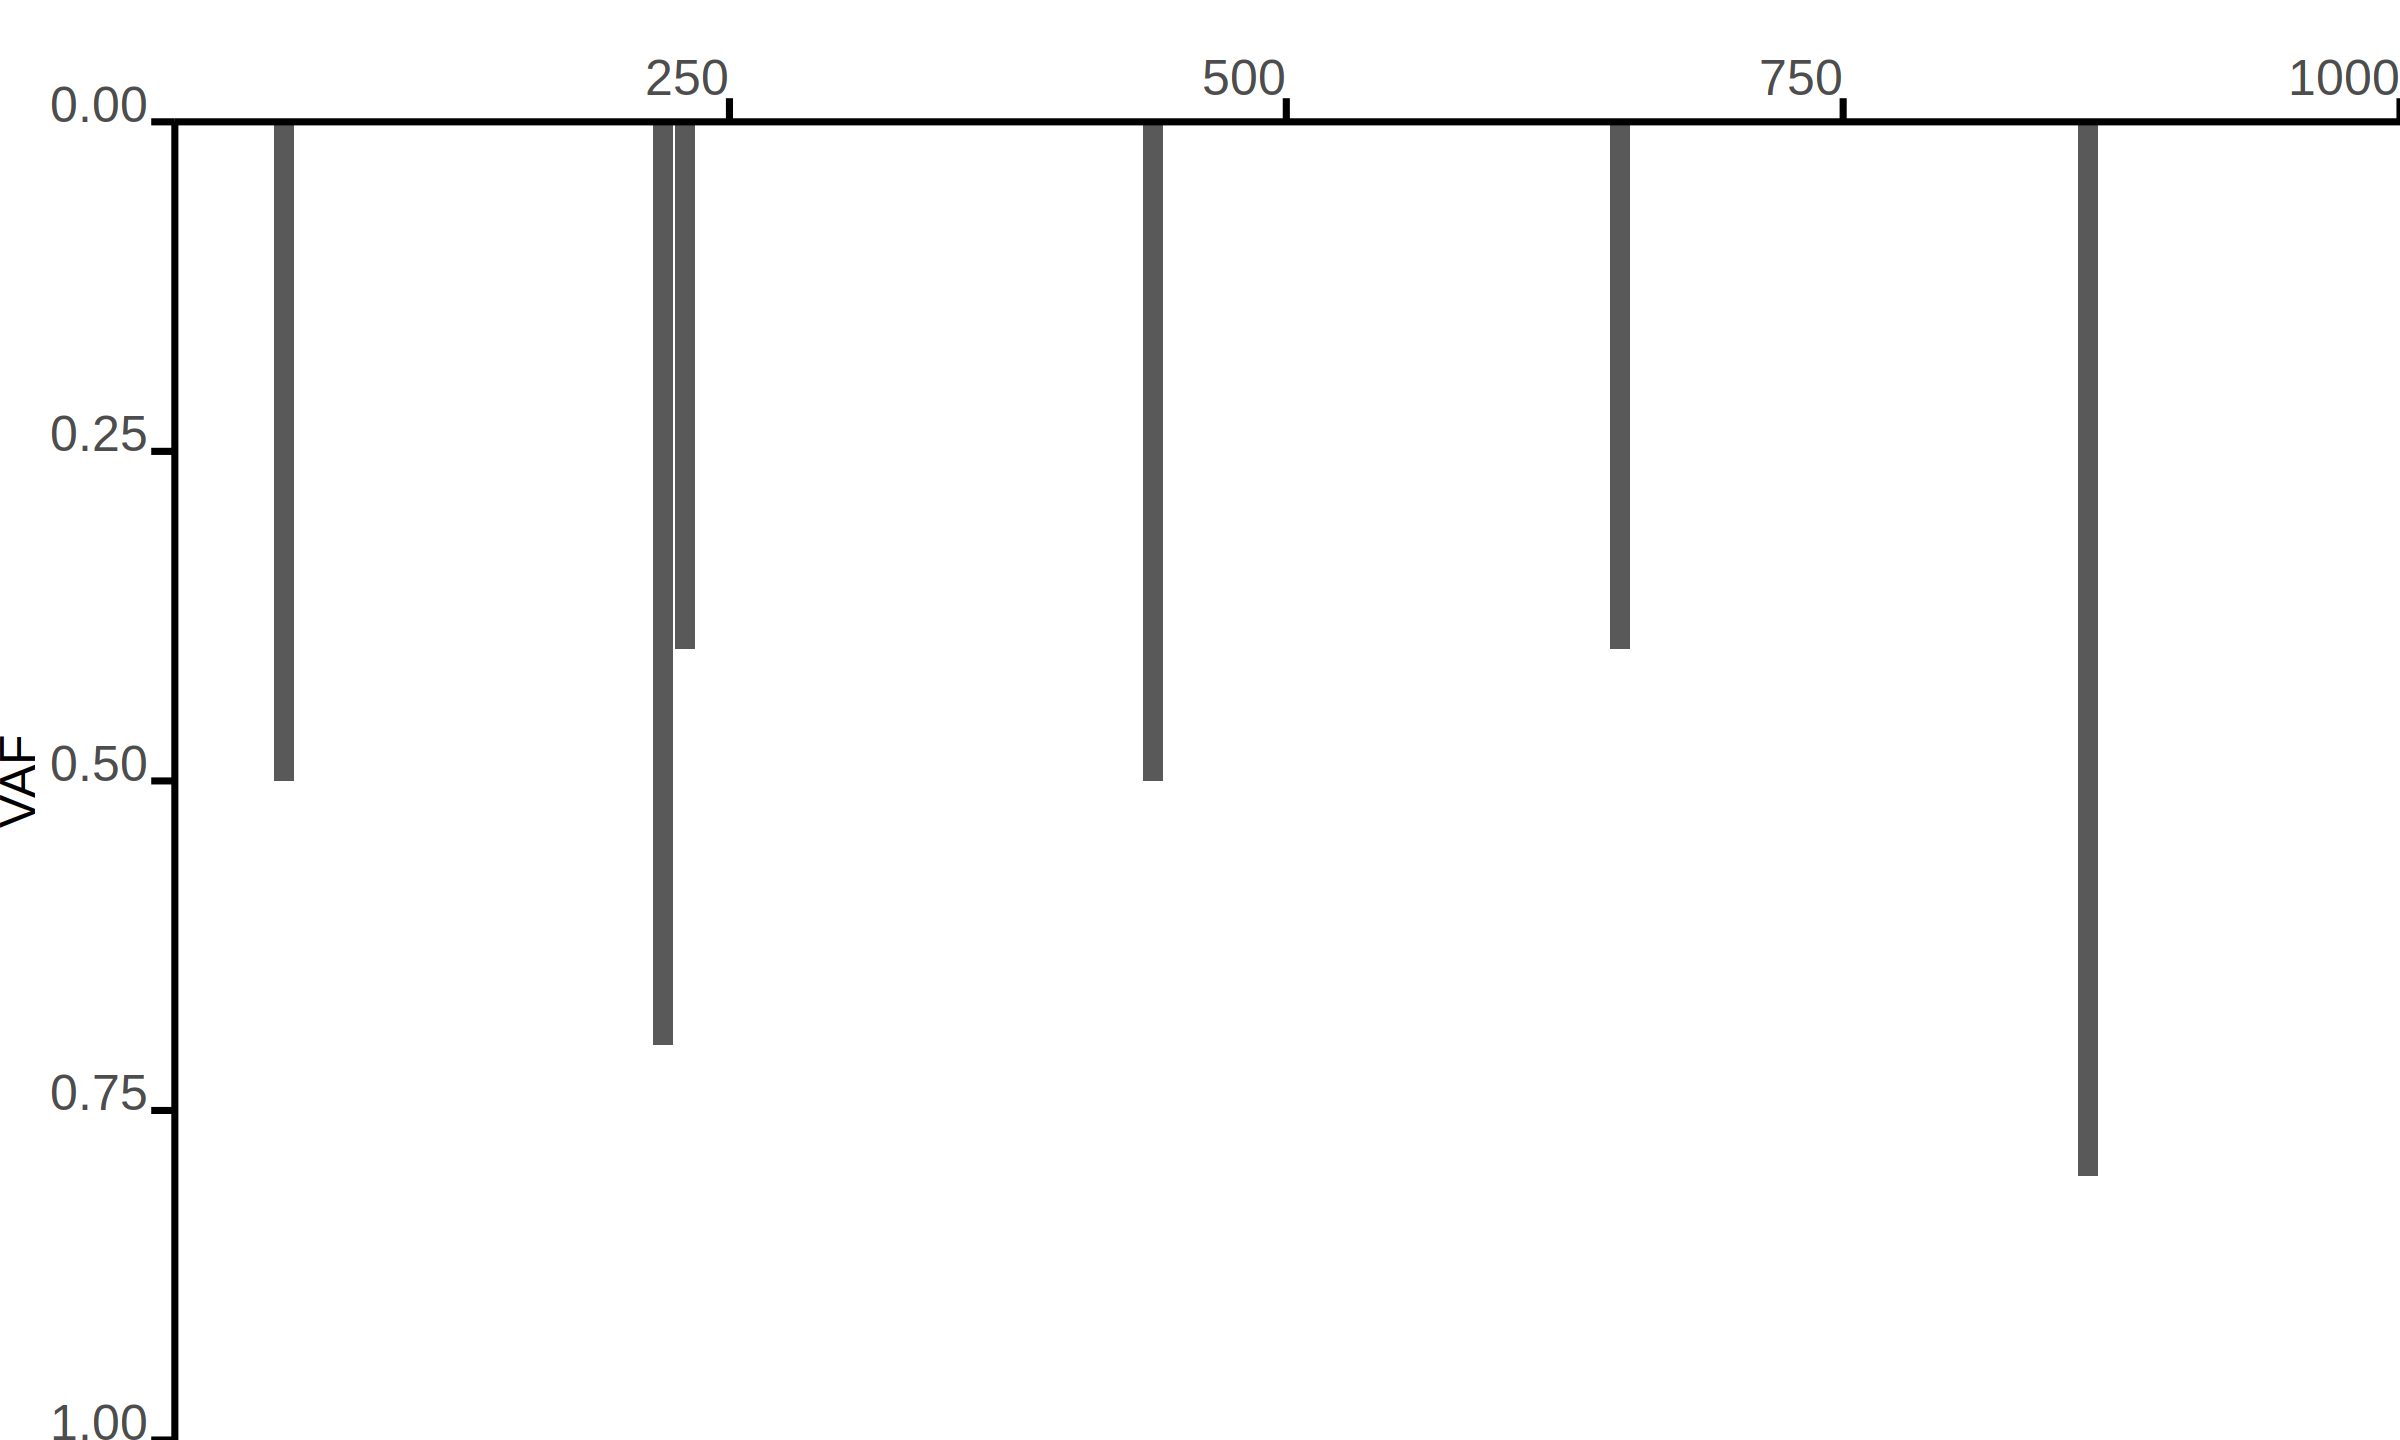

In [12]:
histogram = ggplot(data, aes(x = pos, y = vaf)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_x_continuous(expand = c(0,0), limits = c(1,protein_size), position = "top") +
    scale_y_reverse(expand = c(0,0), limits = c(1,0)) +
    theme_minimal() +
    theme(
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        
        axis.text = element_text(size = 30, vjust = 0, hjust = 1),
        axis.line = element_line(color = "black", linewidth=2),
        
        axis.ticks = element_line(linewidth=2),
        axis.ticks.length = unit(0.5, "cm"),
        
        axis.title = element_text(size = 30),
        
        plot.margin = unit(c(0,0,0,0), "mm"),
        
        legend.position = "none"
    ) +
    labs(x = "", y = "VAF")

histogram

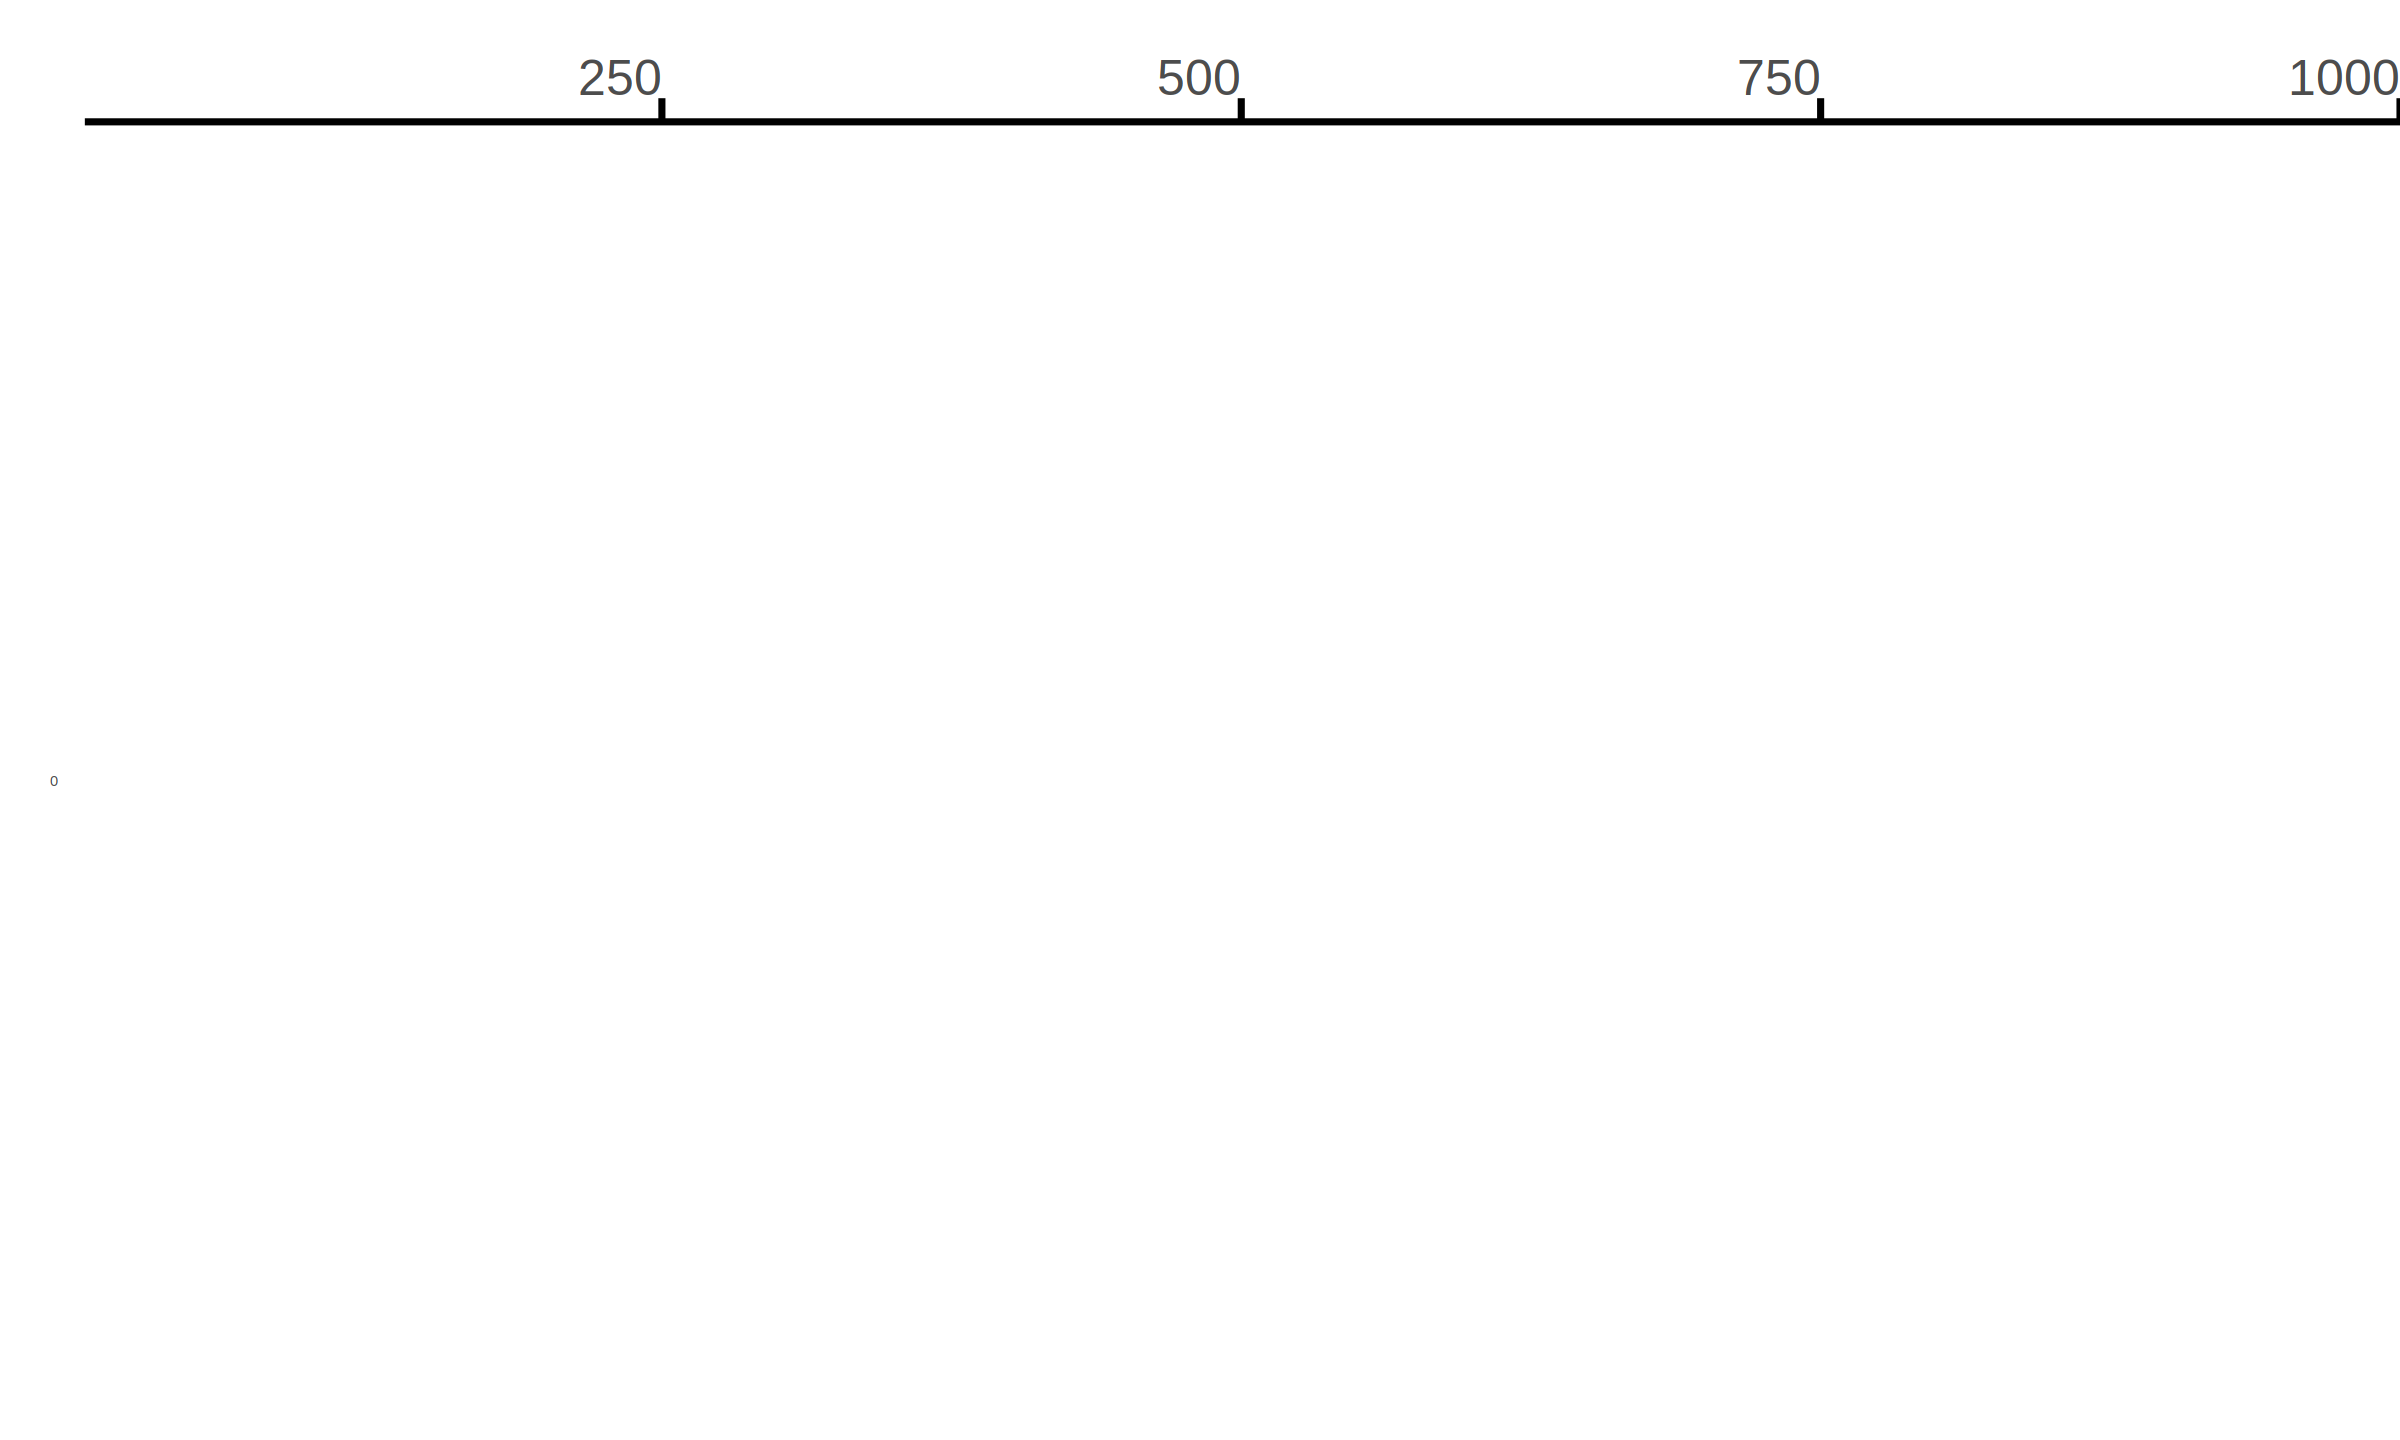

In [13]:
histogram2 = ggplot(data, aes(x = pos, y = 0)) +
    geom_bar(stat = "identity", position = "dodge") +
    scale_x_continuous(expand = c(0,0), limits = c(1,protein_size), position = "top") +
    scale_y_reverse(expand = c(0,0)) +
    theme_minimal() +
    theme(
        panel.background = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),

        axis.text.x = element_text(size = 30, vjust = 0, hjust = 1),
        axis.line.x = element_line(color = "black", linewidth=2),
        
        axis.ticks.x = element_line(linewidth=2),
        axis.ticks.length = unit(0.5, "cm"),
        
        axis.title = element_text(size = 30),
        
        plot.margin = unit(c(0,0,0,0), "mm"),
        
        legend.position = "none"
    ) +
    labs(x = "", y = "")

histogram2

## Merge plots

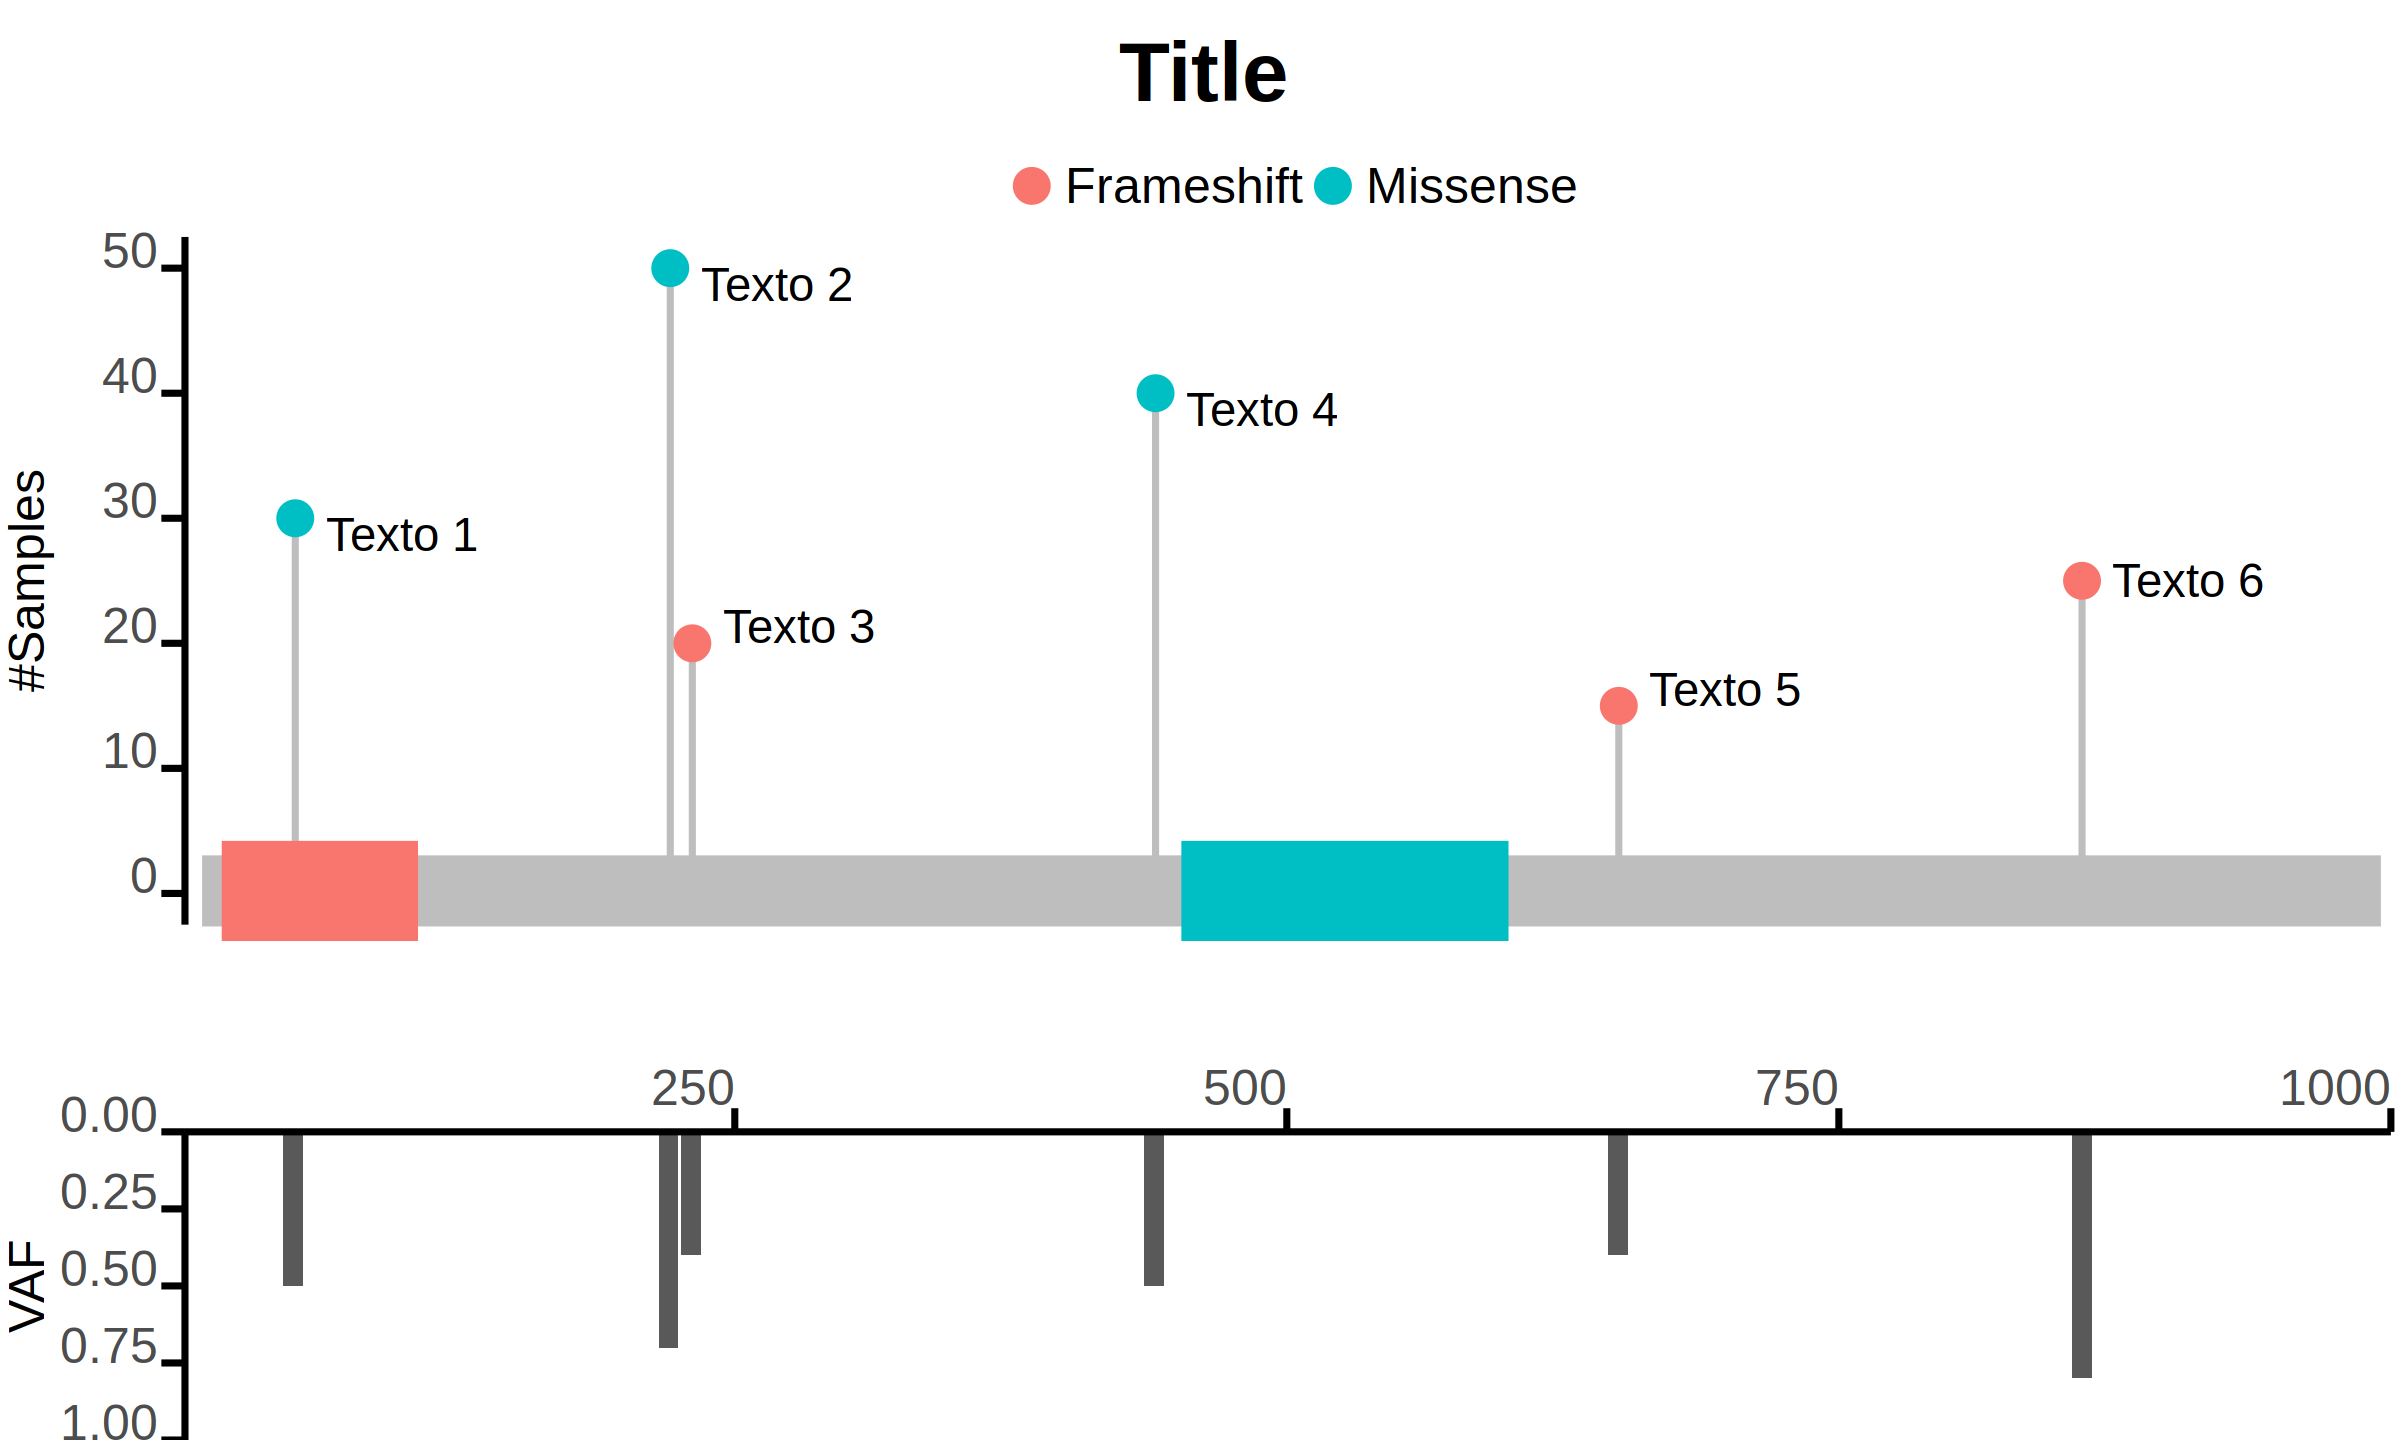

In [14]:
# plot_vaf = TRUE
plot_grid(
    title,
    lollipop,
    histogram,
    nrow = 3,
    align = "v",
    rel_heights = c(1/10, 6/10, 3/10)
)

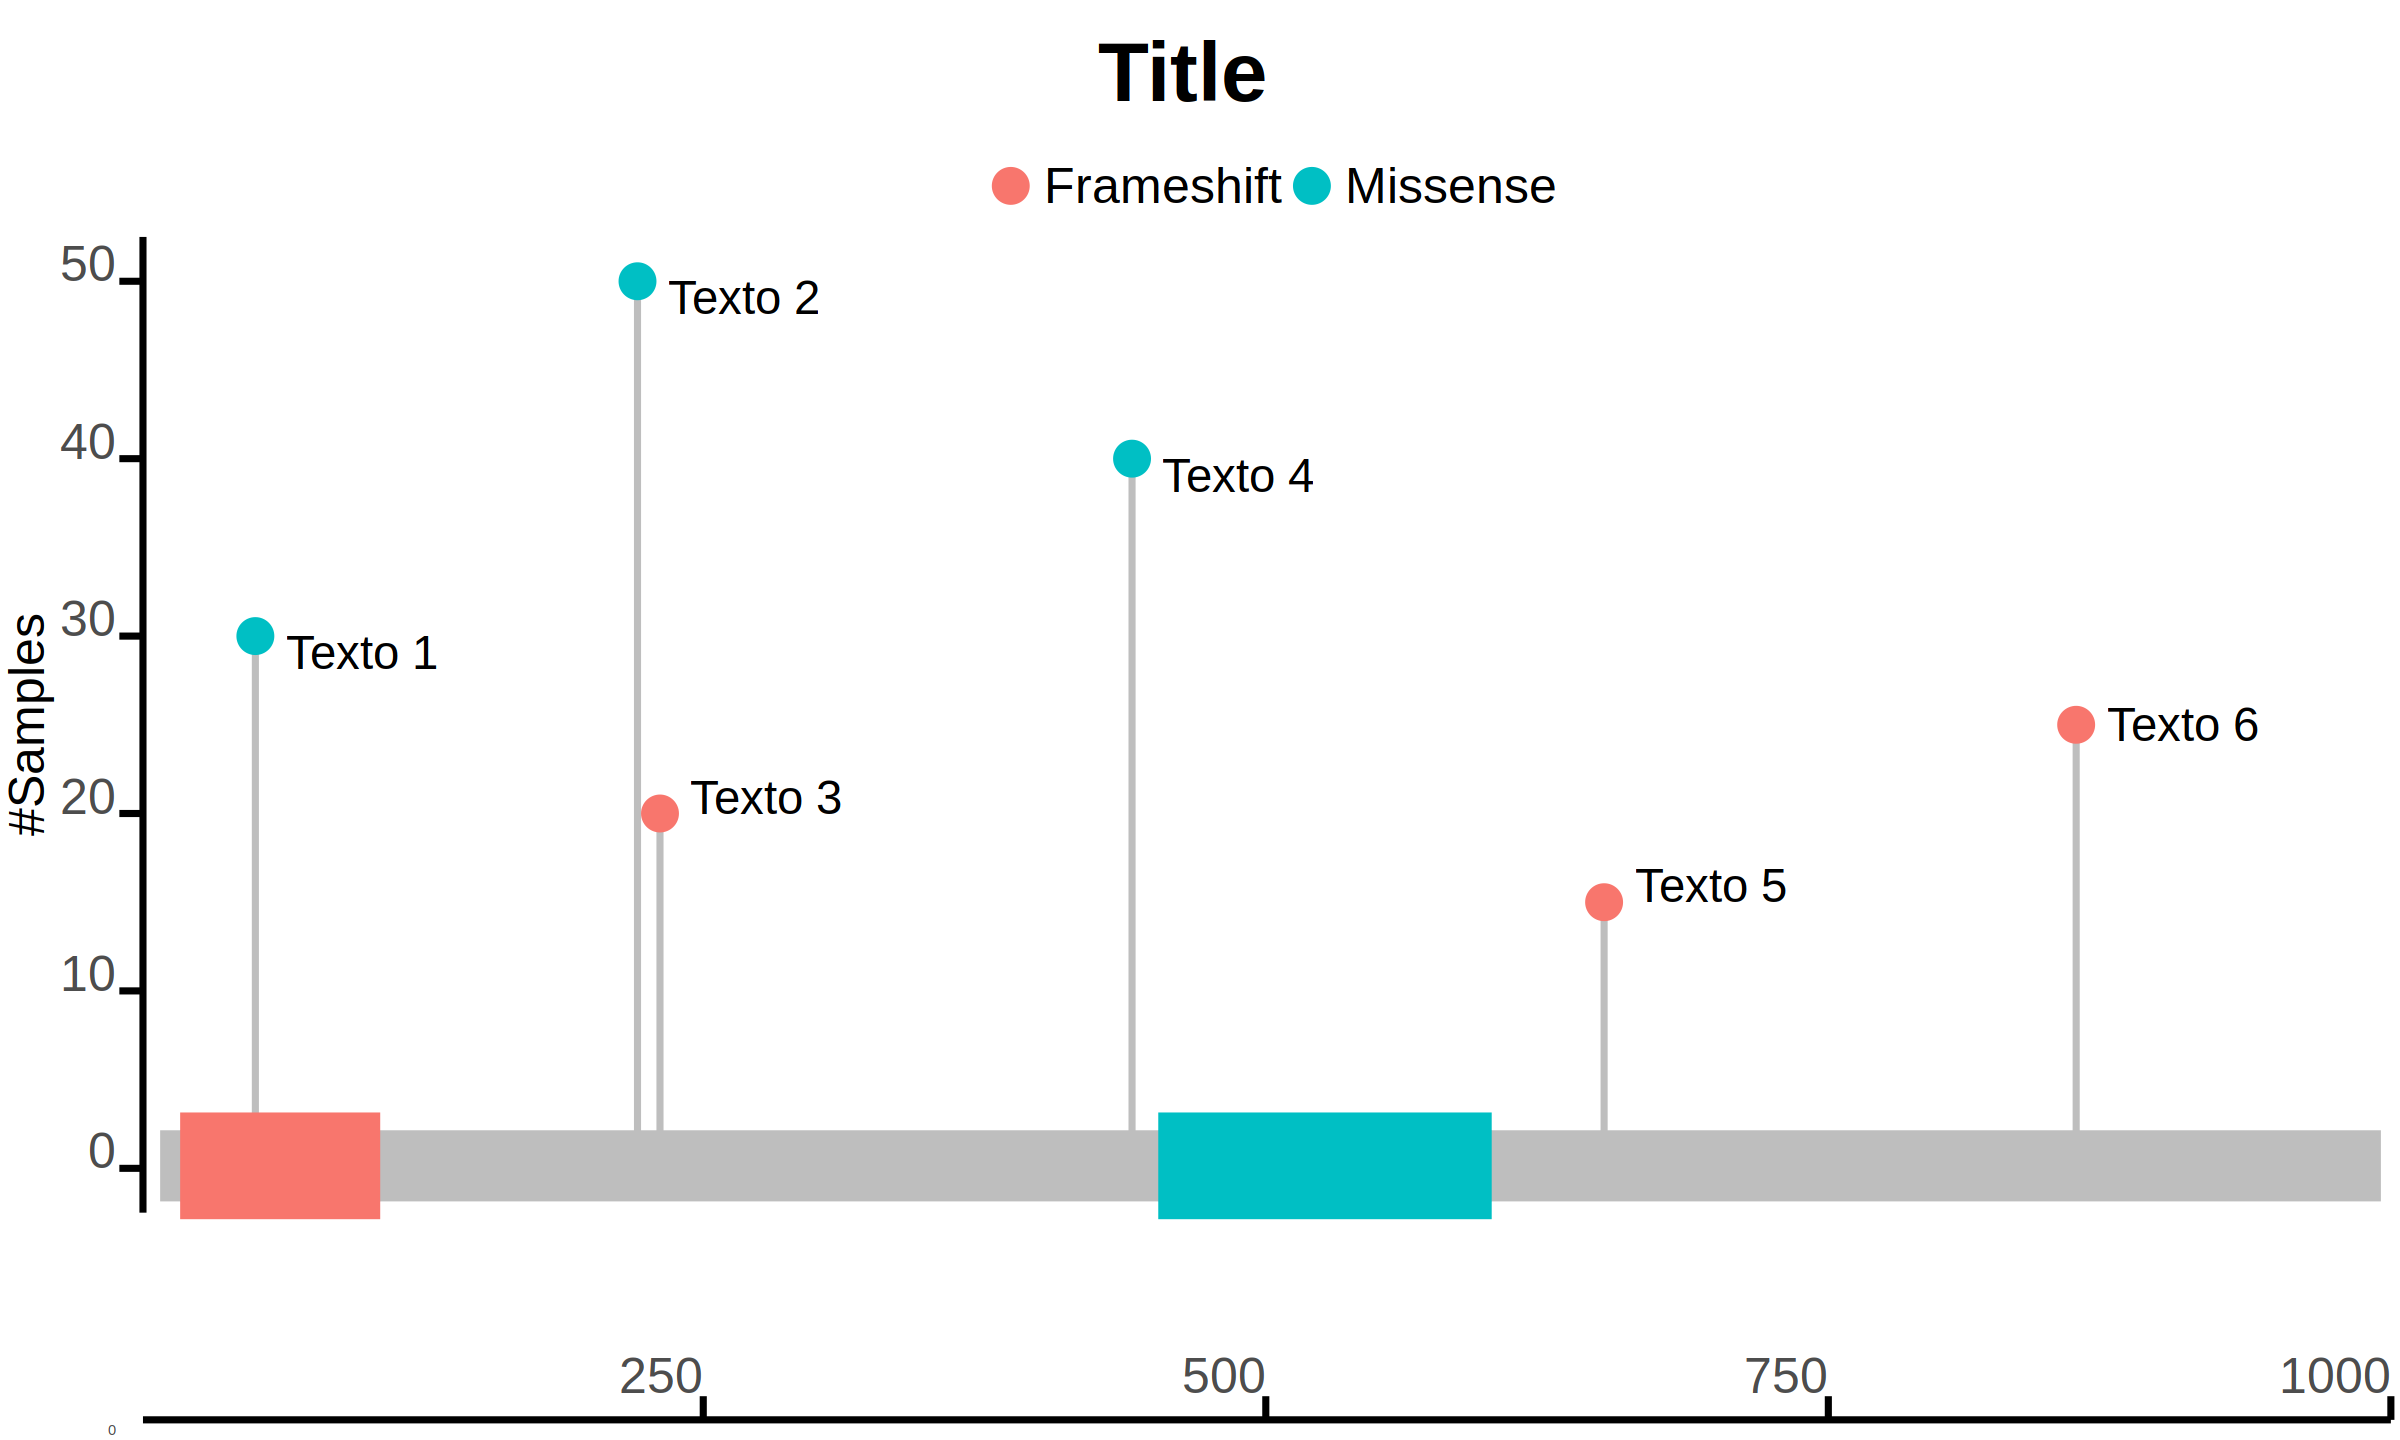

In [15]:
# plot_vaf = FALSE
plot_grid(
    title,
    lollipop,
    histogram2,
    nrow = 3,
    align = "v",
    rel_heights = c(1/10, 8/10, 1/10)
)